# Import libraries

In [21]:
import pandas as pd
from scipy.stats import wilcoxon
import matplotlib.pyplot as plt
from matplotlib import rc
import numpy as np
import utils
import config
import re
import os

In [22]:
# set figure details
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)

# Metadata

In [36]:
metadata = pd.read_csv(os.path.join(config.CLEAN_DIR, "metadata.tsv"), sep="\t", index_col=0)
metadata

Patient_No Hospital Date_Collected Time_Collected Timeline_Weeks  \
Sample_ID                                                                      
magic.0001         101       no       12/10/16           1430              0   
magic.0004         101       no       12/15/16            NaN              1   
magic.0006         104      yes       12/15/16           2335              0   
magic.0007         105      yes       12/15/16           2115              0   
magic.0008         105      yes       12/15/16           1525              0   
...                ...      ...            ...            ...            ...   
magic.6595         588      NaN        8/22/21           1702             96   
magic.6597         595      NaN         9/6/21            NaN             96   
magic.6598         585      NaN        8/23/21            725             96   
magic.6599         573      NaN        7/21/21            845             96   
magic.6600         603      NaN        9/12/21           1600             96   

           Abx_regular Abx_anomoly Abx_timeline.prior..during..after. abx_day  \
Sample_ID                                                                       
magic.0001     regular         NaN                                NaN     NaN   
magic.0004     regular         NaN                                NaN     NaN   
magic.0006     regular         NaN                                NaN     NaN   
magic.0007     regular         NaN                                NaN     NaN   
magic.0008     regular         NaN                                NaN     NaN   
...                ...         ...                                ...     ...   
magic.6595     regular         NaN                                NaN     NaN   
magic.6597     regular         NaN                                NaN     NaN   
magic.6598     regular         NaN                                NaN     NaN   
magic.6599     regular         NaN                                NaN     NaN   
magic.6600     regular         NaN                                NaN     NaN   

           Consistency  ... calc_age_mo currentfeed_bf currentfeed_f  \
Sample_ID               ...                                            
magic.0001         NaN  ...        0.07            1.0           0.0   
magic.0004         NaN  ...        0.23            1.0           0.0   
magic.0006         NaN  ...        0.03            1.0           1.0   
magic.0007         NaN  ...        0.03            1.0           1.0   
magic.0008         NaN  ...        0.03            1.0           1.0   
...                ...  ...         ...            ...           ...   
magic.6595         NaN  ...       24.11            NaN           NaN   
magic.6597      formed  ...       24.11            NaN           NaN   
magic.6598      formed  ...       24.34            NaN           NaN   
magic.6599        soft  ...       24.08            NaN           NaN   
magic.6600      formed  ...       23.88            NaN           NaN   

           currentfeed_o         Sequencing_Project                Filename  \
Sample_ID                                                                     
magic.0001    magic.0001        Knights_Project_046   magic.0001.S22.001.fa   
magic.0004    magic.0004        Knights_Project_046   magic.0004.S34.001.fa   
magic.0006    magic.0006  Knights_Project_076_Pool3  magic.0006.S145.001.fa   
magic.0007    magic.0007  Knights_Project_076_Pool3  magic.0007.S155.001.fa   
magic.0008    magic.0008        Knights_Project_055          X8.S125.001.fa   
...                  ...                        ...                     ...   
magic.6595    magic.6595  Knights_Project_077_Pool3  magic.6595.S253.001.fa   
magic.6597    magic.6597  Knights_Project_077_Pool3  magic.6597.S265.001.fa   
magic.6598    magic.6598  Knights_Project_077_Pool3  magic.6598.S277.001.fa   
magic.6599    magic.6599  Knights_Project_077_Pool3  magic.6599.S288.001.fa   
magic.6600    magic.6600  Knight

In [37]:
genefamilies = pd.read_csv(os.path.join(config.CLEAN_DIR, "humann_genefamilies_clean.tsv"), sep="\t", index_col=0)

gene_richness = (genefamilies > 0).sum(axis=1)
metadata["Gene Richness"] = gene_richness

CAGs = pd.read_csv(os.path.join(config.CLEAN_DIR, "reduced_CAG_profiles_clean.tsv"), sep="\t", index_col=0)
CAG_richness = (CAGs > 0).sum(axis=1)
metadata["CAG Richness"] = CAG_richness

pathways = pd.read_csv(os.path.join(config.CLEAN_DIR, "humann_pathcoverage_clean.tsv"), sep="\t", index_col=0)

pathway_richness = (pathways > 0.75).sum(axis=1)
metadata["Pathway Richness"] = pathway_richness

species = pd.read_csv(os.path.join(config.CLEAN_DIR, "gtdb_species.tsv"), sep="\t", index_col=0)
species_richness = (species > 0.00001).sum(axis=1)
metadata["Species Richness"] = species_richness

metadata

Patient_No Hospital Date_Collected Time_Collected Timeline_Weeks  \
Sample_ID                                                                      
magic.0001         101       no       12/10/16           1430              0   
magic.0004         101       no       12/15/16            NaN              1   
magic.0006         104      yes       12/15/16           2335              0   
magic.0007         105      yes       12/15/16           2115              0   
magic.0008         105      yes       12/15/16           1525              0   
...                ...      ...            ...            ...            ...   
magic.6595         588      NaN        8/22/21           1702             96   
magic.6597         595      NaN         9/6/21            NaN             96   
magic.6598         585      NaN        8/23/21            725             96   
magic.6599         573      NaN        7/21/21            845             96   
magic.6600         603      NaN        9/12/21           1600             96   

           Abx_regular Abx_anomoly Abx_timeline.prior..during..after. abx_day  \
Sample_ID                                                                       
magic.0001     regular         NaN                                NaN     NaN   
magic.0004     regular         NaN                                NaN     NaN   
magic.0006     regular         NaN                                NaN     NaN   
magic.0007     regular         NaN                                NaN     NaN   
magic.0008     regular         NaN                                NaN     NaN   
...                ...         ...                                ...     ...   
magic.6595     regular         NaN                                NaN     NaN   
magic.6597     regular         NaN                                NaN     NaN   
magic.6598     regular         NaN                                NaN     NaN   
magic.6599     regular         NaN                                NaN     NaN   
magic.6600     regular         NaN                                NaN     NaN   

           Consistency  ...         Sequencing_Project  \
Sample_ID               ...                              
magic.0001         NaN  ...        Knights_Project_046   
magic.0004         NaN  ...        Knights_Project_046   
magic.0006         NaN  ...  Knights_Project_076_Pool3   
magic.0007         NaN  ...  Knights_Project_076_Pool3   
magic.0008         NaN  ...        Knights_Project_055   
...                ...  ...                        ...   
magic.6595         NaN  ...  Knights_Project_077_Pool3   
magic.6597      formed  ...  Knights_Project_077_Pool3   
magic.6598      formed  ...  Knights_Project_077_Pool3   
magic.6599        soft  ...  Knights_Project_077_Pool3   
magic.6600      formed  ...  Knights_Project_077_Pool3   

                          Filename    Extraction    depth  \
Sample_ID                                                   
magic.0001   magic.0001.S22.001.fa    MagAttract  1544781   
magic.0004   magic.0004.S34.001.fa    MagAttract  1167038   
magic.0006  magic.0006.S145.001.fa     PowerSoil  1720636   
magic.0007  magic.0007.S155.001.fa     PowerSoil  6825017   
magic.0008          X8.S125.001.fa     PowerSoil  2928044   
...                            ...           ...      ...   
magic.6595  magic.6595.S253.001.fa  PowerSoilPro  1562968   
magic.6597  magic.6597.S265.001.fa  PowerSoilPro  2113880   
magic.6598  magic.6598.S277.001.fa  PowerSoilPro  1650388   
magic.6599  magic.6599.S288.001.fa  PowerSoilPro  1519641   
magic.6600  magic.6600.S361.001.fa  PowerSoilPro  1389563   

            bos_taurus_read_count  unreduced_gene_richness  Gene Richness  \
Sample_ID                                                                   
magic.0001                     37                  64331.0           7764   
magic.0004                     30                  69105.0           7753   
magic.0006                  13268                  21372.0  

In [38]:
metadata["birthmode"] = metadata["expo_cat2"]
birthmodes = metadata["birthmode"].unique()
display(birthmodes)
metadata

array(['Vaginal', 'C-section with labor', 'C-section without labor'],
      dtype=object)

Patient_No Hospital Date_Collected Time_Collected Timeline_Weeks  \
Sample_ID                                                                      
magic.0001         101       no       12/10/16           1430              0   
magic.0004         101       no       12/15/16            NaN              1   
magic.0006         104      yes       12/15/16           2335              0   
magic.0007         105      yes       12/15/16           2115              0   
magic.0008         105      yes       12/15/16           1525              0   
...                ...      ...            ...            ...            ...   
magic.6595         588      NaN        8/22/21           1702             96   
magic.6597         595      NaN         9/6/21            NaN             96   
magic.6598         585      NaN        8/23/21            725             96   
magic.6599         573      NaN        7/21/21            845             96   
magic.6600         603      NaN        9/12/21           1600             96   

           Abx_regular Abx_anomoly Abx_timeline.prior..during..after. abx_day  \
Sample_ID                                                                       
magic.0001     regular         NaN                                NaN     NaN   
magic.0004     regular         NaN                                NaN     NaN   
magic.0006     regular         NaN                                NaN     NaN   
magic.0007     regular         NaN                                NaN     NaN   
magic.0008     regular         NaN                                NaN     NaN   
...                ...         ...                                ...     ...   
magic.6595     regular         NaN                                NaN     NaN   
magic.6597     regular         NaN                                NaN     NaN   
magic.6598     regular         NaN                                NaN     NaN   
magic.6599     regular         NaN                                NaN     NaN   
magic.6600     regular         NaN                                NaN     NaN   

           Consistency  ...                Filename    Extraction    depth  \
Sample_ID               ...                                                  
magic.0001         NaN  ...   magic.0001.S22.001.fa    MagAttract  1544781   
magic.0004         NaN  ...   magic.0004.S34.001.fa    MagAttract  1167038   
magic.0006         NaN  ...  magic.0006.S145.001.fa     PowerSoil  1720636   
magic.0007         NaN  ...  magic.0007.S155.001.fa     PowerSoil  6825017   
magic.0008         NaN  ...          X8.S125.001.fa     PowerSoil  2928044   
...                ...  ...                     ...           ...      ...   
magic.6595         NaN  ...  magic.6595.S253.001.fa  PowerSoilPro  1562968   
magic.6597      formed  ...  magic.6597.S265.001.fa  PowerSoilPro  2113880   
magic.6598      formed  ...  magic.6598.S277.001.fa  PowerSoilPro  1650388   
magic.6599        soft  ...  magic.6599.S288.001.fa  PowerSoilPro  1519641   
magic.6600      formed  ...  magic.6600.S361.001.fa  PowerSoilPro  1389563   

           bos_taurus_read_count  unreduced_gene_richness  Gene Richness  \
Sample_ID                                                                  
magic.0001                    37                  64331.0           7764   
magic.0004                    30                  69105.0           7753   
magic.0006                 13268                  21372.0           2888   
magic.0007                  3304                  89717.0           8650   
magic.0008                   476                  61474.0           7908   
...                          ...                      ...            ...   
magic.6595                  2761                 185844.0           3745   
magic.6597                  2339                 176610.0           1928   
magic.6598                  1853                 142285.0           4586   
magic.6599                  1694                 155385.0         

In [39]:
metadata["timepoint"] = metadata["Timeline_Weeks"]

has_time_info = ~metadata["Timeline_Weeks"].isna() & (metadata["Timeline_Weeks"] != "na")
metadata = metadata.loc[has_time_info]
metadata

Patient_No Hospital Date_Collected Time_Collected Timeline_Weeks  \
Sample_ID                                                                      
magic.0001         101       no       12/10/16           1430              0   
magic.0004         101       no       12/15/16            NaN              1   
magic.0006         104      yes       12/15/16           2335              0   
magic.0007         105      yes       12/15/16           2115              0   
magic.0008         105      yes       12/15/16           1525              0   
...                ...      ...            ...            ...            ...   
magic.6595         588      NaN        8/22/21           1702             96   
magic.6597         595      NaN         9/6/21            NaN             96   
magic.6598         585      NaN        8/23/21            725             96   
magic.6599         573      NaN        7/21/21            845             96   
magic.6600         603      NaN        9/12/21           1600             96   

           Abx_regular Abx_anomoly Abx_timeline.prior..during..after. abx_day  \
Sample_ID                                                                       
magic.0001     regular         NaN                                NaN     NaN   
magic.0004     regular         NaN                                NaN     NaN   
magic.0006     regular         NaN                                NaN     NaN   
magic.0007     regular         NaN                                NaN     NaN   
magic.0008     regular         NaN                                NaN     NaN   
...                ...         ...                                ...     ...   
magic.6595     regular         NaN                                NaN     NaN   
magic.6597     regular         NaN                                NaN     NaN   
magic.6598     regular         NaN                                NaN     NaN   
magic.6599     regular         NaN                                NaN     NaN   
magic.6600     regular         NaN                                NaN     NaN   

           Consistency  ...    Extraction    depth bos_taurus_read_count  \
Sample_ID               ...                                                
magic.0001         NaN  ...    MagAttract  1544781                    37   
magic.0004         NaN  ...    MagAttract  1167038                    30   
magic.0006         NaN  ...     PowerSoil  1720636                 13268   
magic.0007         NaN  ...     PowerSoil  6825017                  3304   
magic.0008         NaN  ...     PowerSoil  2928044                   476   
...                ...  ...           ...      ...                   ...   
magic.6595         NaN  ...  PowerSoilPro  1562968                  2761   
magic.6597      formed  ...  PowerSoilPro  2113880                  2339   
magic.6598      formed  ...  PowerSoilPro  1650388                  1853   
magic.6599        soft  ...  PowerSoilPro  1519641                  1694   
magic.6600      formed  ...  PowerSoilPro  1389563                   734   

           unreduced_gene_richness  Gene Richness  CAG Richness  \
Sample_ID                                                         
magic.0001                 64331.0           7764           119   
magic.0004                 69105.0           7753           119   
magic.0006                 21372.0           2888            52   
magic.0007                 89717.0           8650           146   
magic.0008                 61474.0           7908           129   
...                            ...            ...           ...   
magic.6595                185844.0           3745           119   
magic.6597                176610.0           1928            73   
magic.6598                142285.0           4586           112   
magic.6599                155385.0           3658            92   
magic.6600                 92319.0           1192            64   

            Pathway Richness  Species Richness          

In [40]:
metadata.index = metadata["Patient_No"]
metadata["timepoint_plot"] = [int(time) for time in metadata["timepoint"]]
# metadata["timepoint_plot"] = metadata["timepoint_plot"].apply(lambda x : {0 : 0, 1 : 1, 2 : 2, 3 : 3, 4 : 4, 
#     12: 5, 24 : 6, 36 : 7, 48 : 8, 60 : 9, 72 : 10, 84 : 11, 96 : 12}[x])
metadata

/Users/daniel/opt/anaconda3/envs/data/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Patient_No Hospital Date_Collected Time_Collected Timeline_Weeks  \
Patient_No                                                                     
101                101       no       12/10/16           1430              0   
101                101       no       12/15/16            NaN              1   
104                104      yes       12/15/16           2335              0   
105                105      yes       12/15/16           2115              0   
105                105      yes       12/15/16           1525              0   
...                ...      ...            ...            ...            ...   
588                588      NaN        8/22/21           1702             96   
595                595      NaN         9/6/21            NaN             96   
585                585      NaN        8/23/21            725             96   
573                573      NaN        7/21/21            845             96   
603                603      NaN        9/12/21           1600             96   

           Abx_regular Abx_anomoly Abx_timeline.prior..during..after. abx_day  \
Patient_No                                                                      
101            regular         NaN                                NaN     NaN   
101            regular         NaN                                NaN     NaN   
104            regular         NaN                                NaN     NaN   
105            regular         NaN                                NaN     NaN   
105            regular         NaN                                NaN     NaN   
...                ...         ...                                ...     ...   
588            regular         NaN                                NaN     NaN   
595            regular         NaN                                NaN     NaN   
585            regular         NaN                                NaN     NaN   
573            regular         NaN                                NaN     NaN   
603            regular         NaN                                NaN     NaN   

           Consistency  ...    depth bos_taurus_read_count  \
Patient_No              ...                                  
101                NaN  ...  1544781                    37   
101                NaN  ...  1167038                    30   
104                NaN  ...  1720636                 13268   
105                NaN  ...  6825017                  3304   
105                NaN  ...  2928044                   476   
...                ...  ...      ...                   ...   
588                NaN  ...  1562968                  2761   
595             formed  ...  2113880                  2339   
585             formed  ...  1650388                  1853   
573               soft  ...  1519641                  1694   
603             formed  ...  1389563                   734   

           unreduced_gene_richness Gene Richness  CAG Richness  \
Patient_No                                                       
101                        64331.0          7764           119   
101                        69105.0          7753           119   
104                        21372.0          2888            52   
105                        89717.0          8650           146   
105                        61474.0          7908           129   
...                            ...           ...           ...   
588                       185844.0          3745           119   
595                       176610.0          1928            73   
585                       142285.0          4586           112   
573                       155385.0          3658            92   
603                        92319.0          1192            64   

            Pathway Richness  Species Richness             birthmode  \
Patient_No                                                             
101                       37               451               Vaginal   
101                       28       

In [41]:
timepoints_sorted = np.unique(metadata["Timeline_Weeks"])
timepoints_sorted = sorted(timepoints_sorted, key=lambda x : int(x))

Vaginal                    269
C-section with labor        77
C-section without labor     47
Name: birthmode, dtype: int64


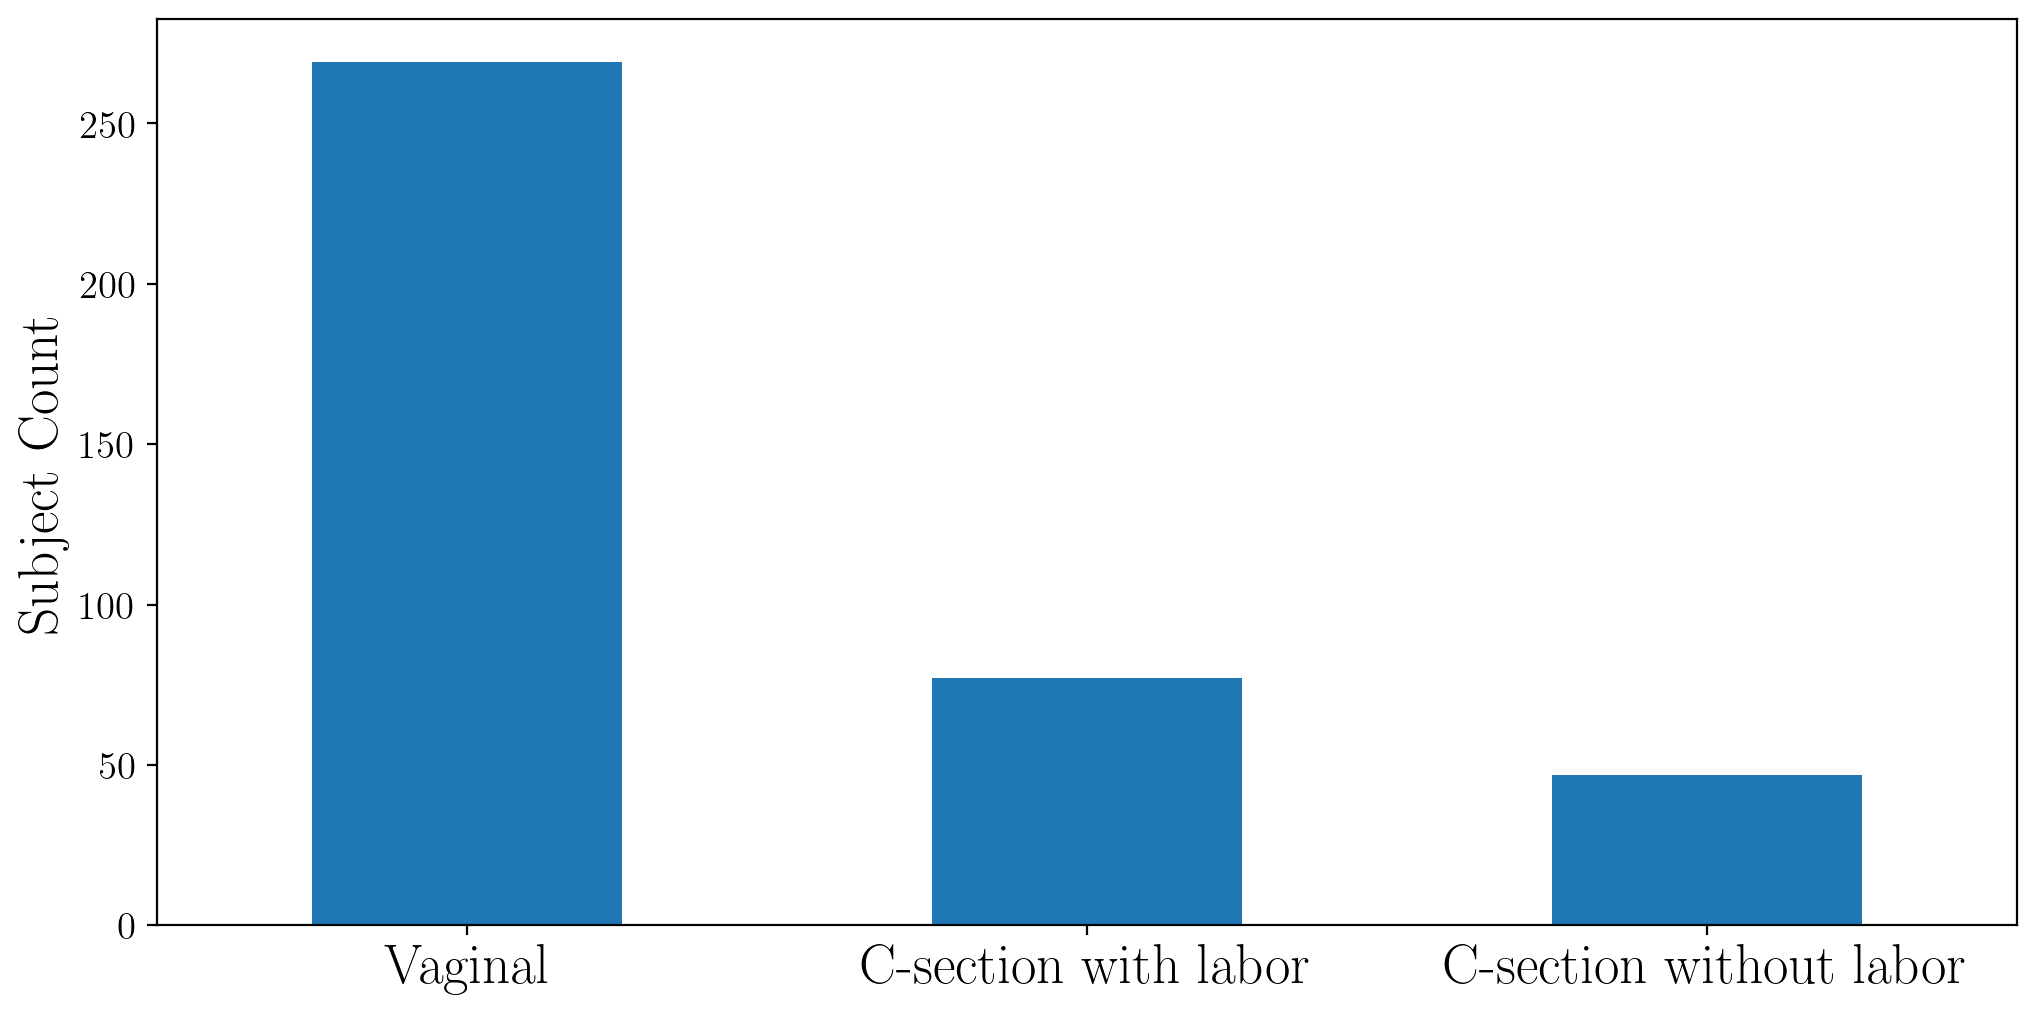

In [42]:
plt.figure(figsize=(12, 6), dpi=200)
birthmode_counts = metadata.drop_duplicates("Patient_No")["birthmode"].value_counts()
print(birthmode_counts)
birthmode_counts.plot.bar()
plt.ylabel("Subject Count", fontsize=20)
ax = plt.gca()
ax.tick_params(axis='x', which='major', labelsize=20, rotation=0)
ax.tick_params(axis='y', which='major', labelsize=14)

In [43]:
def plot_index(index):
    for birthmode in birthmodes:
        print(birthmode)
        fig = plt.figure(figsize=(16, 4), dpi=200)
        ax = plt.gca()
        
        plotted_longitudinal = []

        subjects = np.unique(metadata.index)
        for subject in subjects:
            df = metadata.loc[[subject]].copy()
            df = df[df["birthmode"] == birthmode]
            df = df.sort_values("timepoint_plot")
            df = df.drop_duplicates("Timeline_Weeks")
            plotted_longitudinal.append(df)
            ax.plot(df["timepoint_plot"], df[index], c="gray", zorder=0, alpha=0.2)
        ax.set_xticks([int(t) for t in timepoints_sorted])
        ax.set_xticklabels(timepoints_sorted)
        ax.set_ylabel(index, fontsize=18)
        ax.set_xlabel("Time point (weeks)", fontsize=18)
        
        plotted_df = pd.concat(plotted_longitudinal)

        for i, time in enumerate(timepoints_sorted):
            data = plotted_df[plotted_df["timepoint"] == time][index]
            sc = ax.scatter(np.ones(data.shape[0]) * int(time), data, s=2 if i < 5 else 10)
            c = sc.get_facecolors()[0].tolist()
            width = 2.0 if i < 5 else 2
            widths = 0.75 if i < 5 else 3
            bp = ax.boxplot(data, positions=[int(time)], patch_artist=True, widths=[widths],
                boxprops=dict(facecolor=[0, 0, 0, 0], color=c, linewidth=width),
                capprops=dict(color=c, linewidth=0),
                whiskerprops=dict(color=c, linewidth=width),
                flierprops=dict(color=c, markeredgecolor=c, linewidth=width),
                medianprops=dict(color=c, linewidth=width))

Vaginal
C-section with labor
C-section without labor


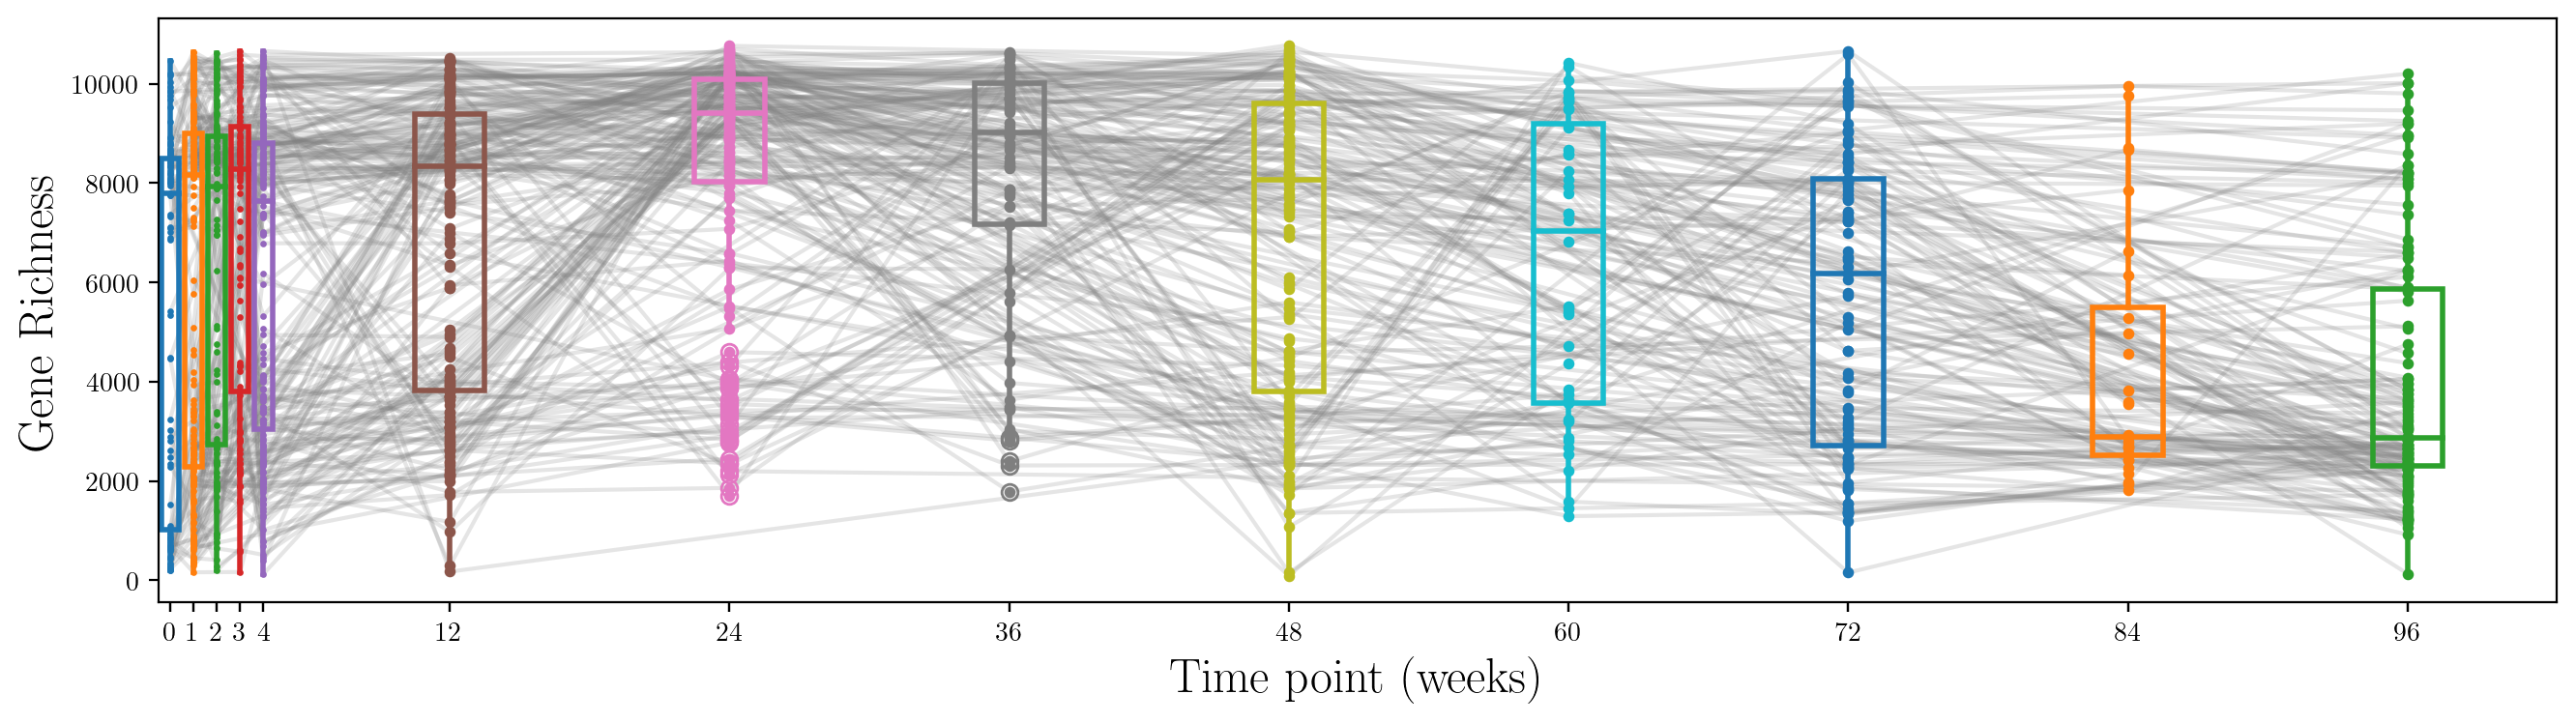

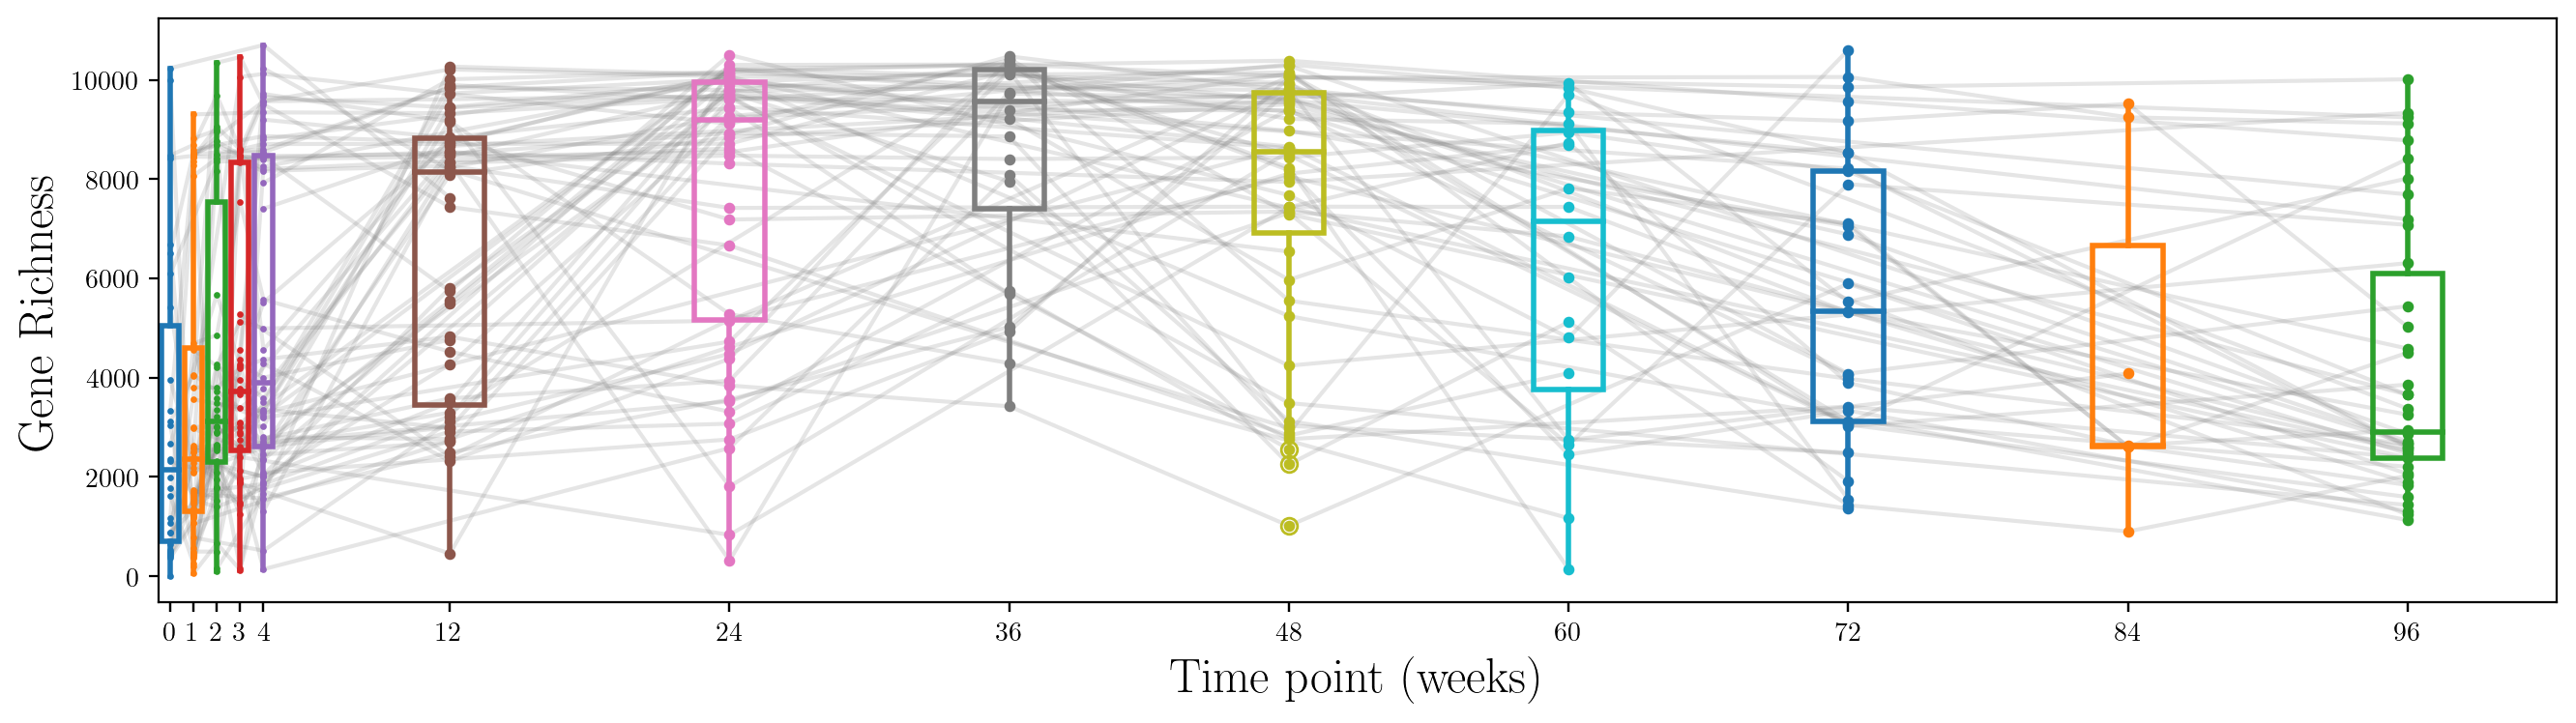

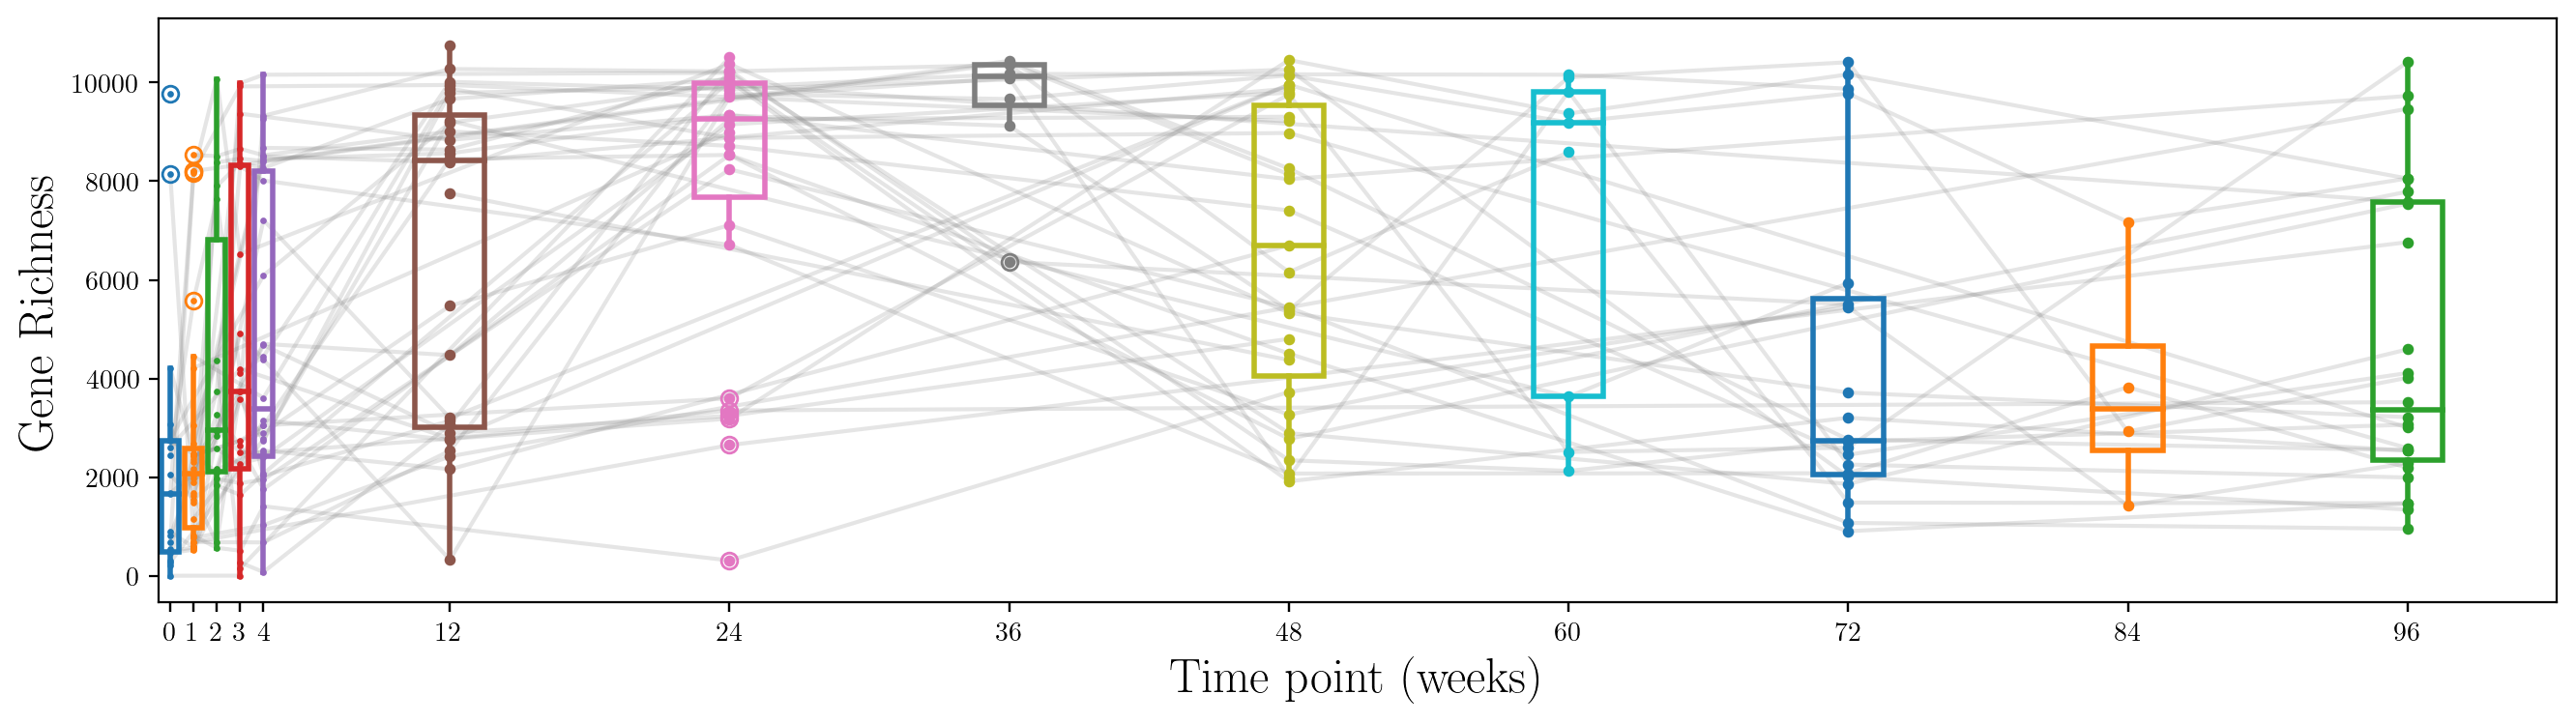

In [44]:
plot_index("Gene Richness")

/Users/daniel/opt/anaconda3/envs/data/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


Vaginal
C-section with labor
C-section without labor


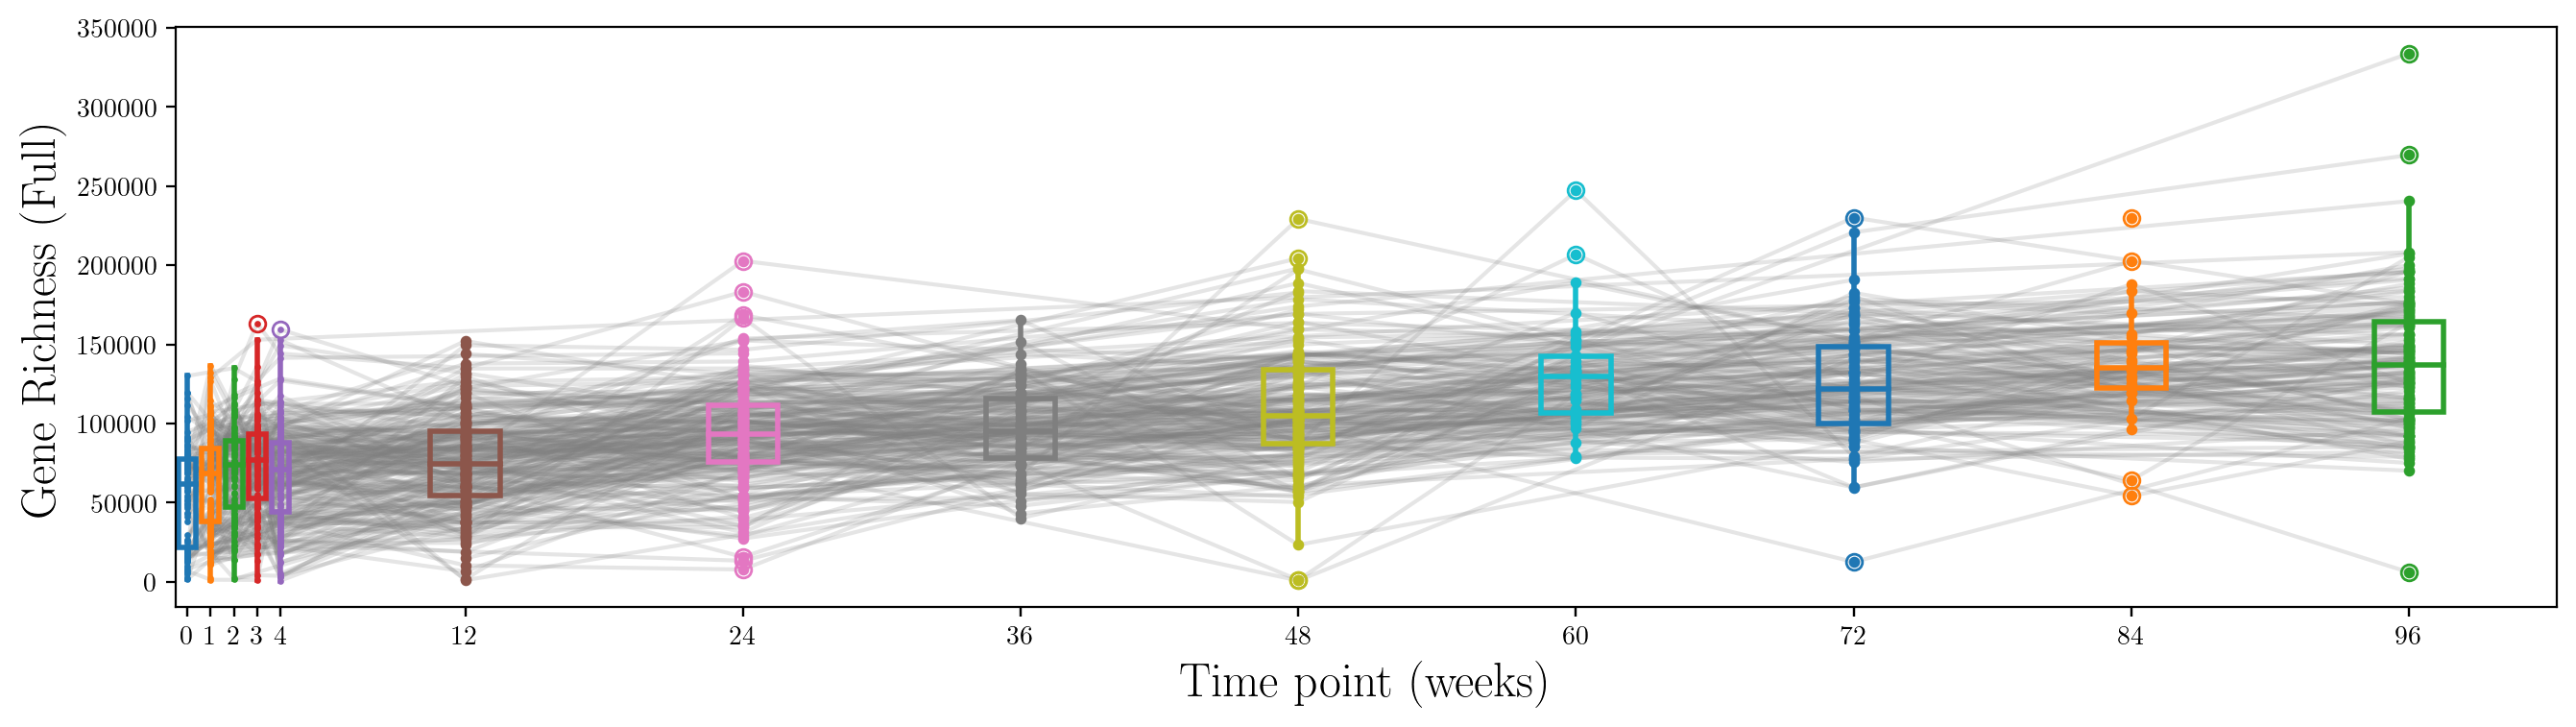

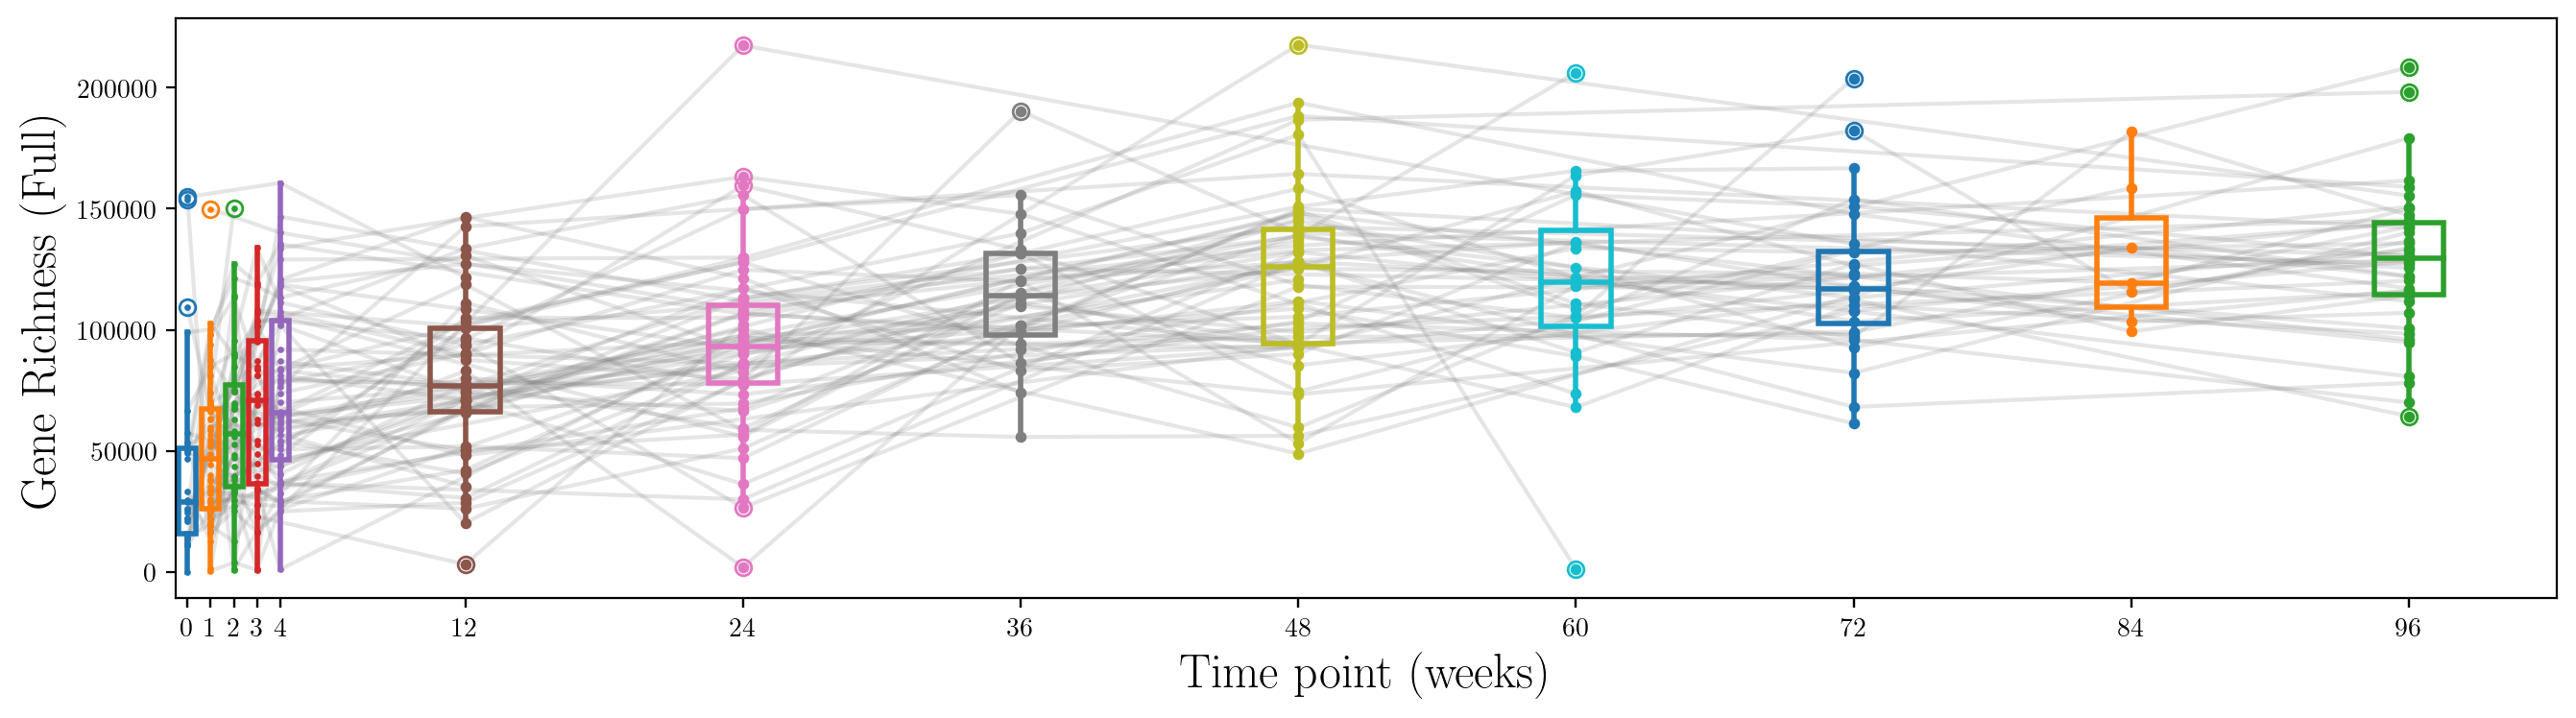

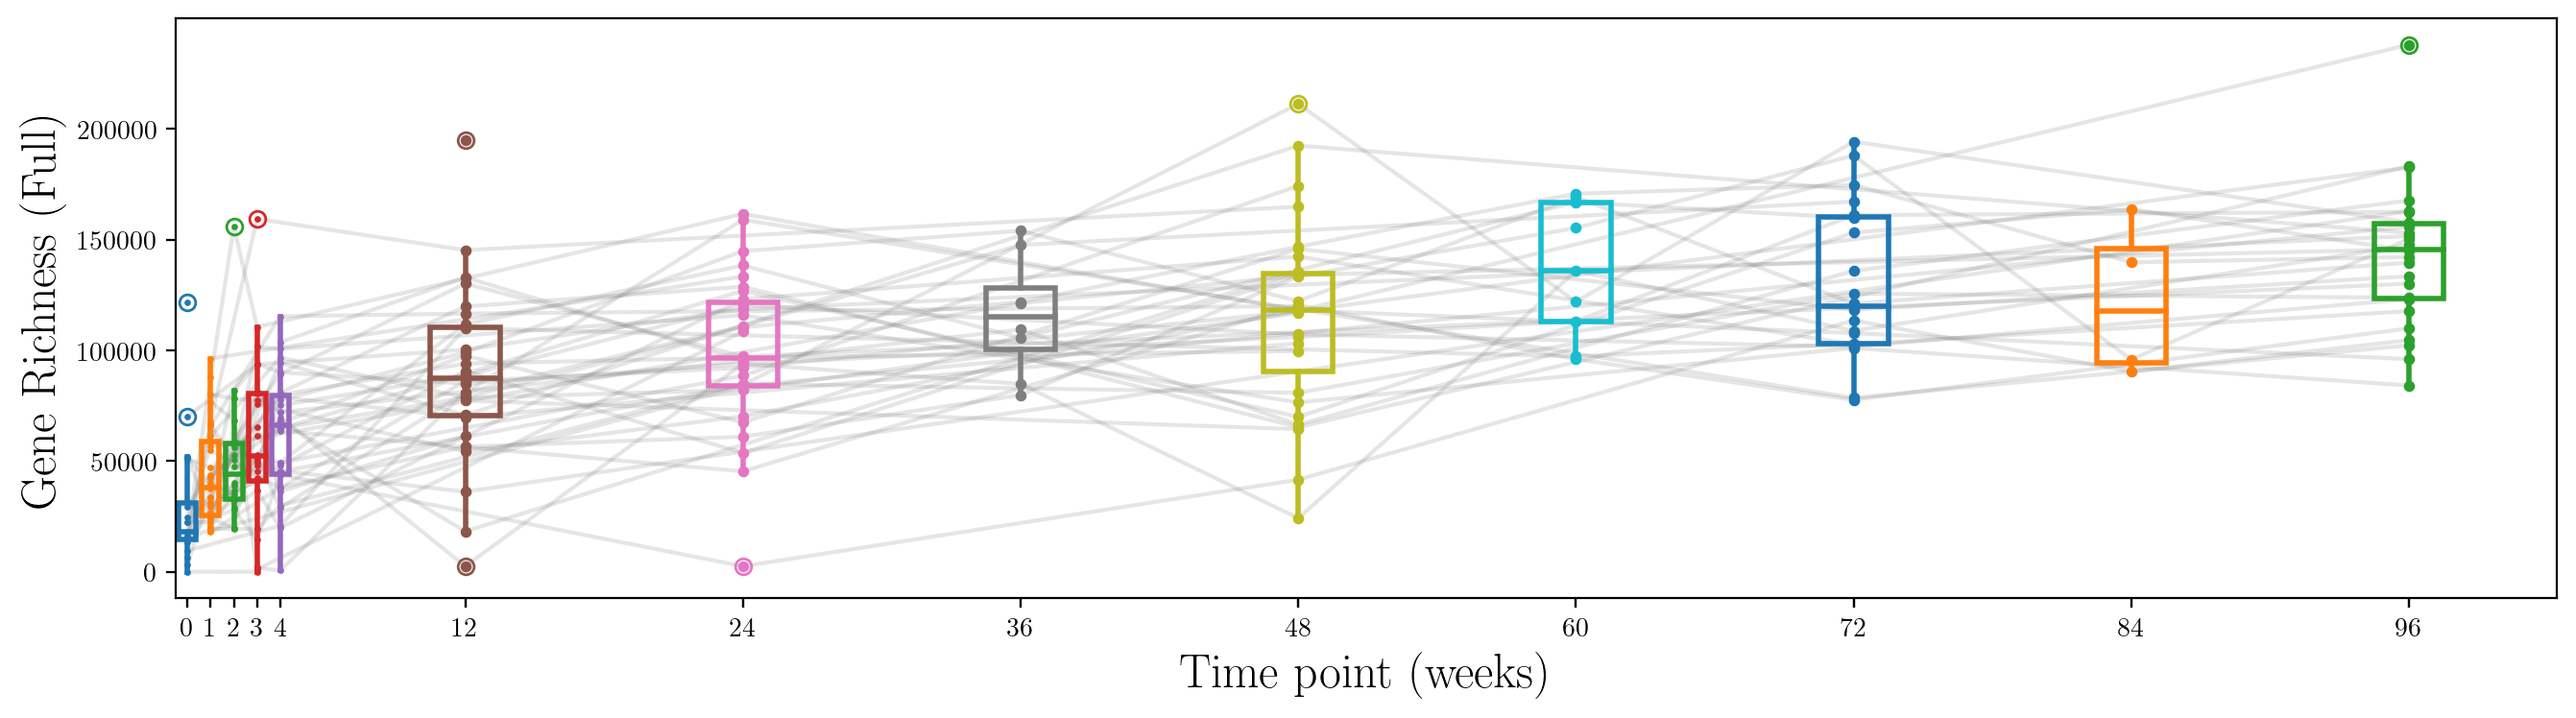

In [45]:
metadata["Gene Richness (Full)"] = metadata["unreduced_gene_richness"]

plot_index("Gene Richness (Full)")

Vaginal
C-section with labor
C-section without labor


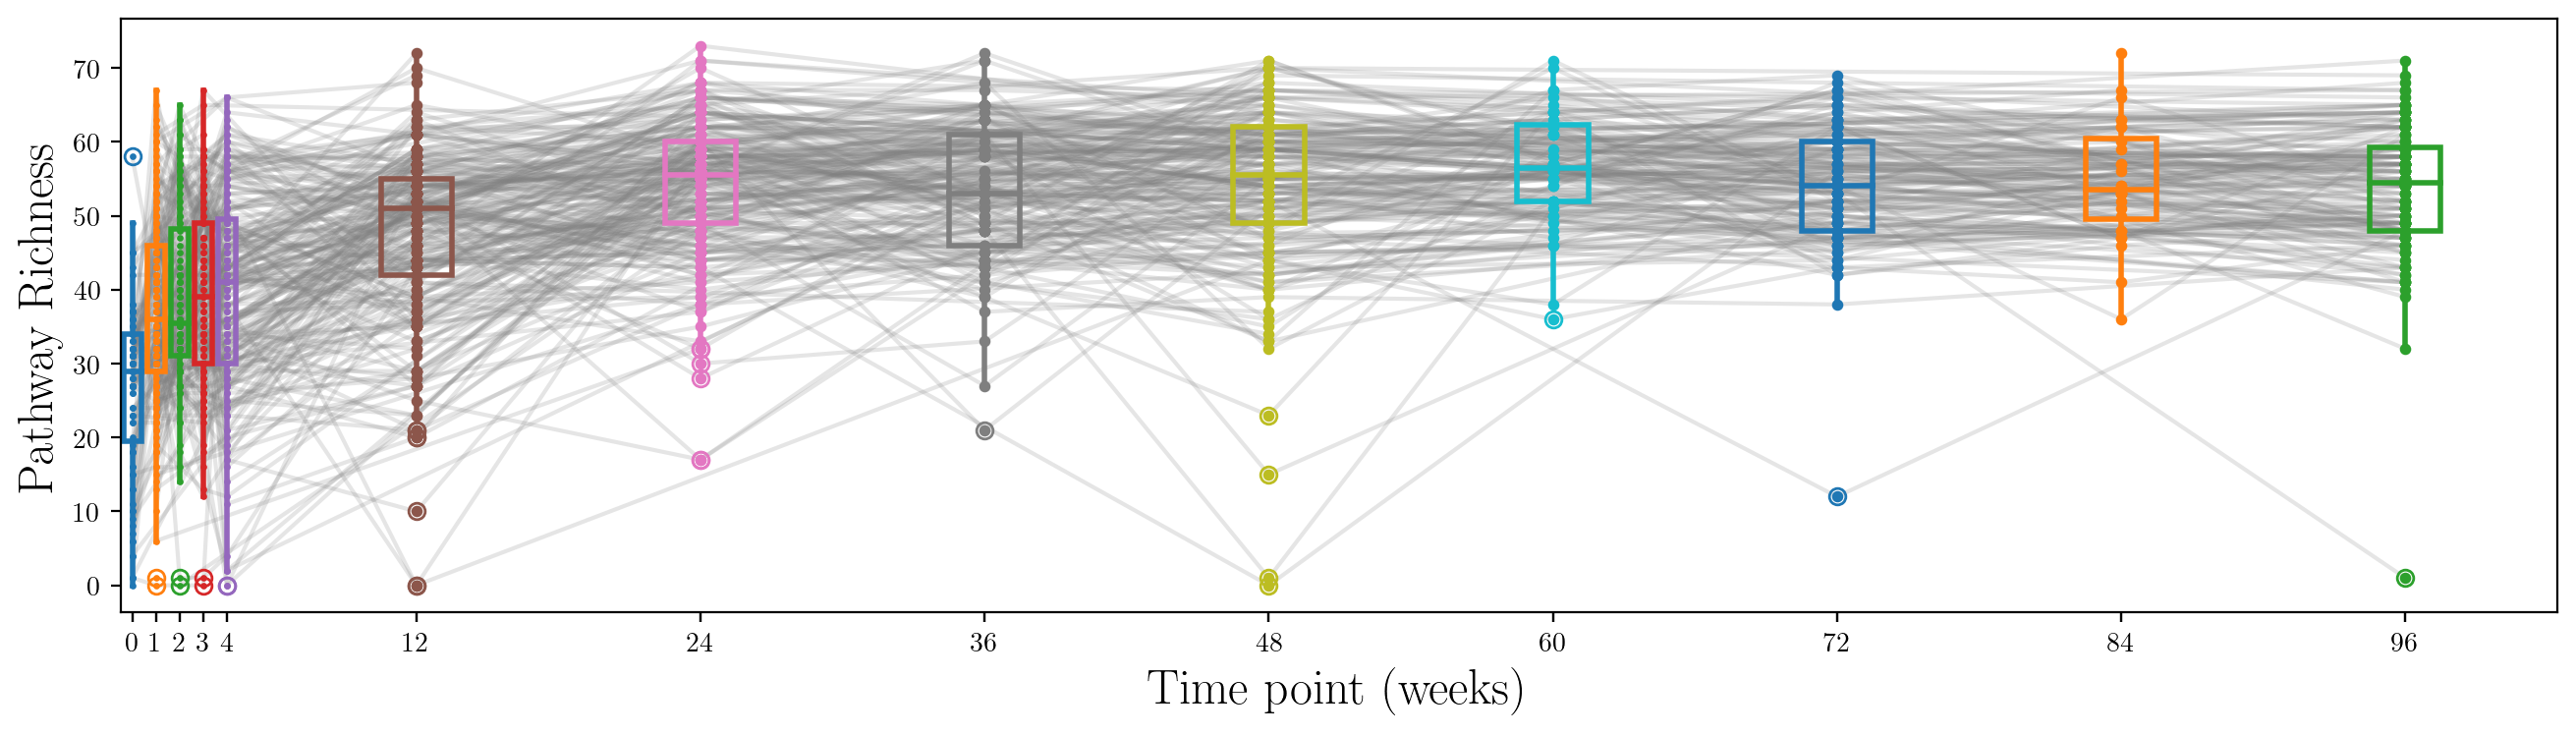

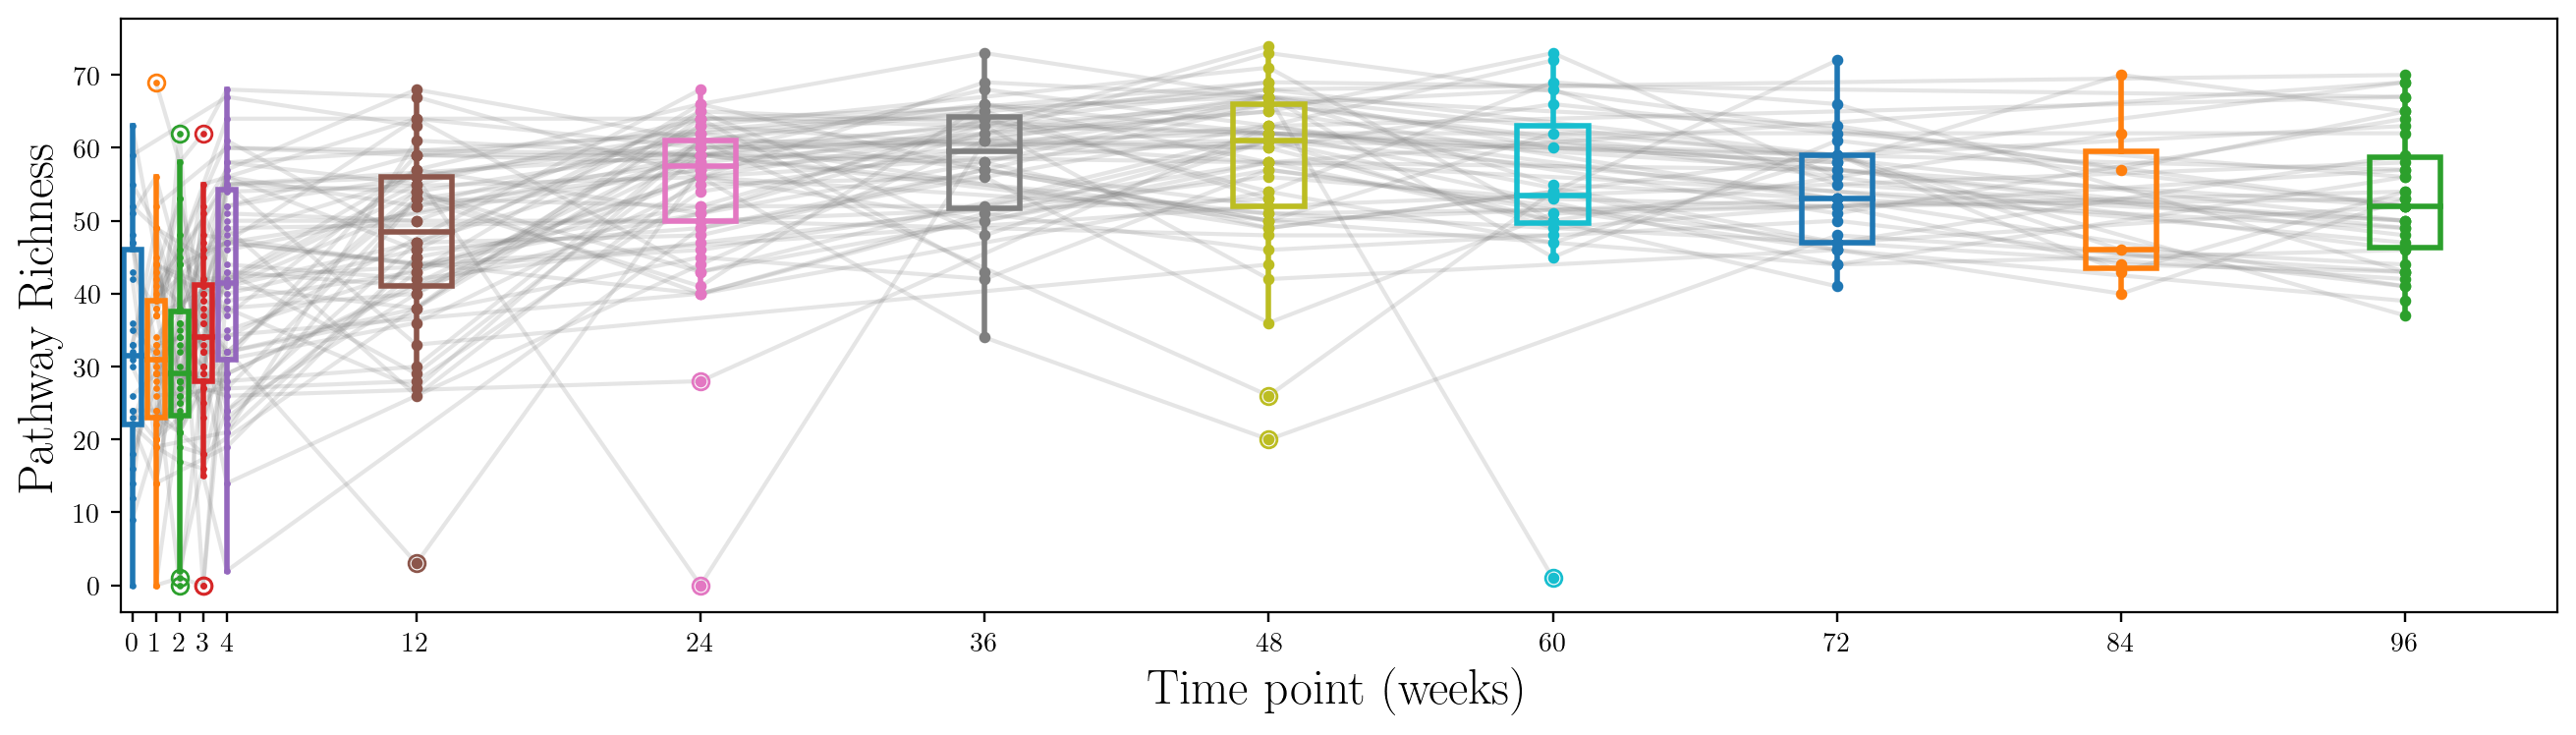

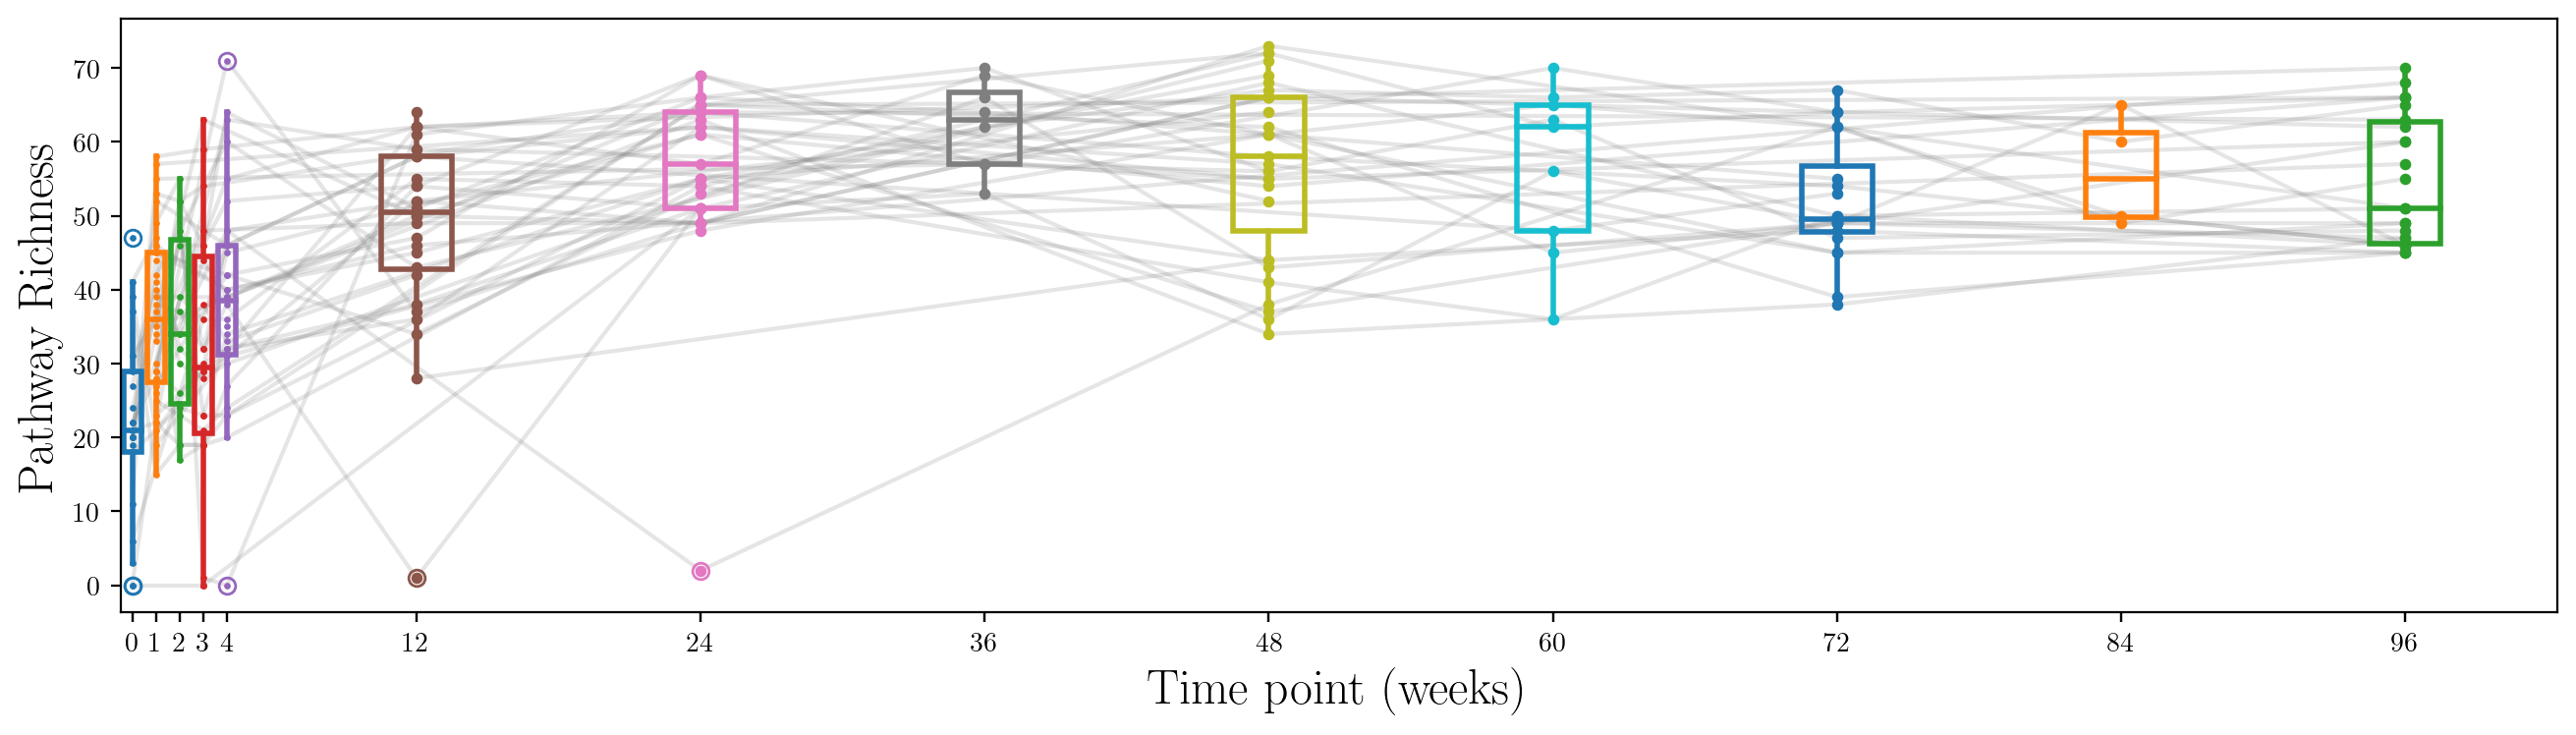

In [46]:
plot_index("Pathway Richness")

Vaginal
C-section with labor
C-section without labor


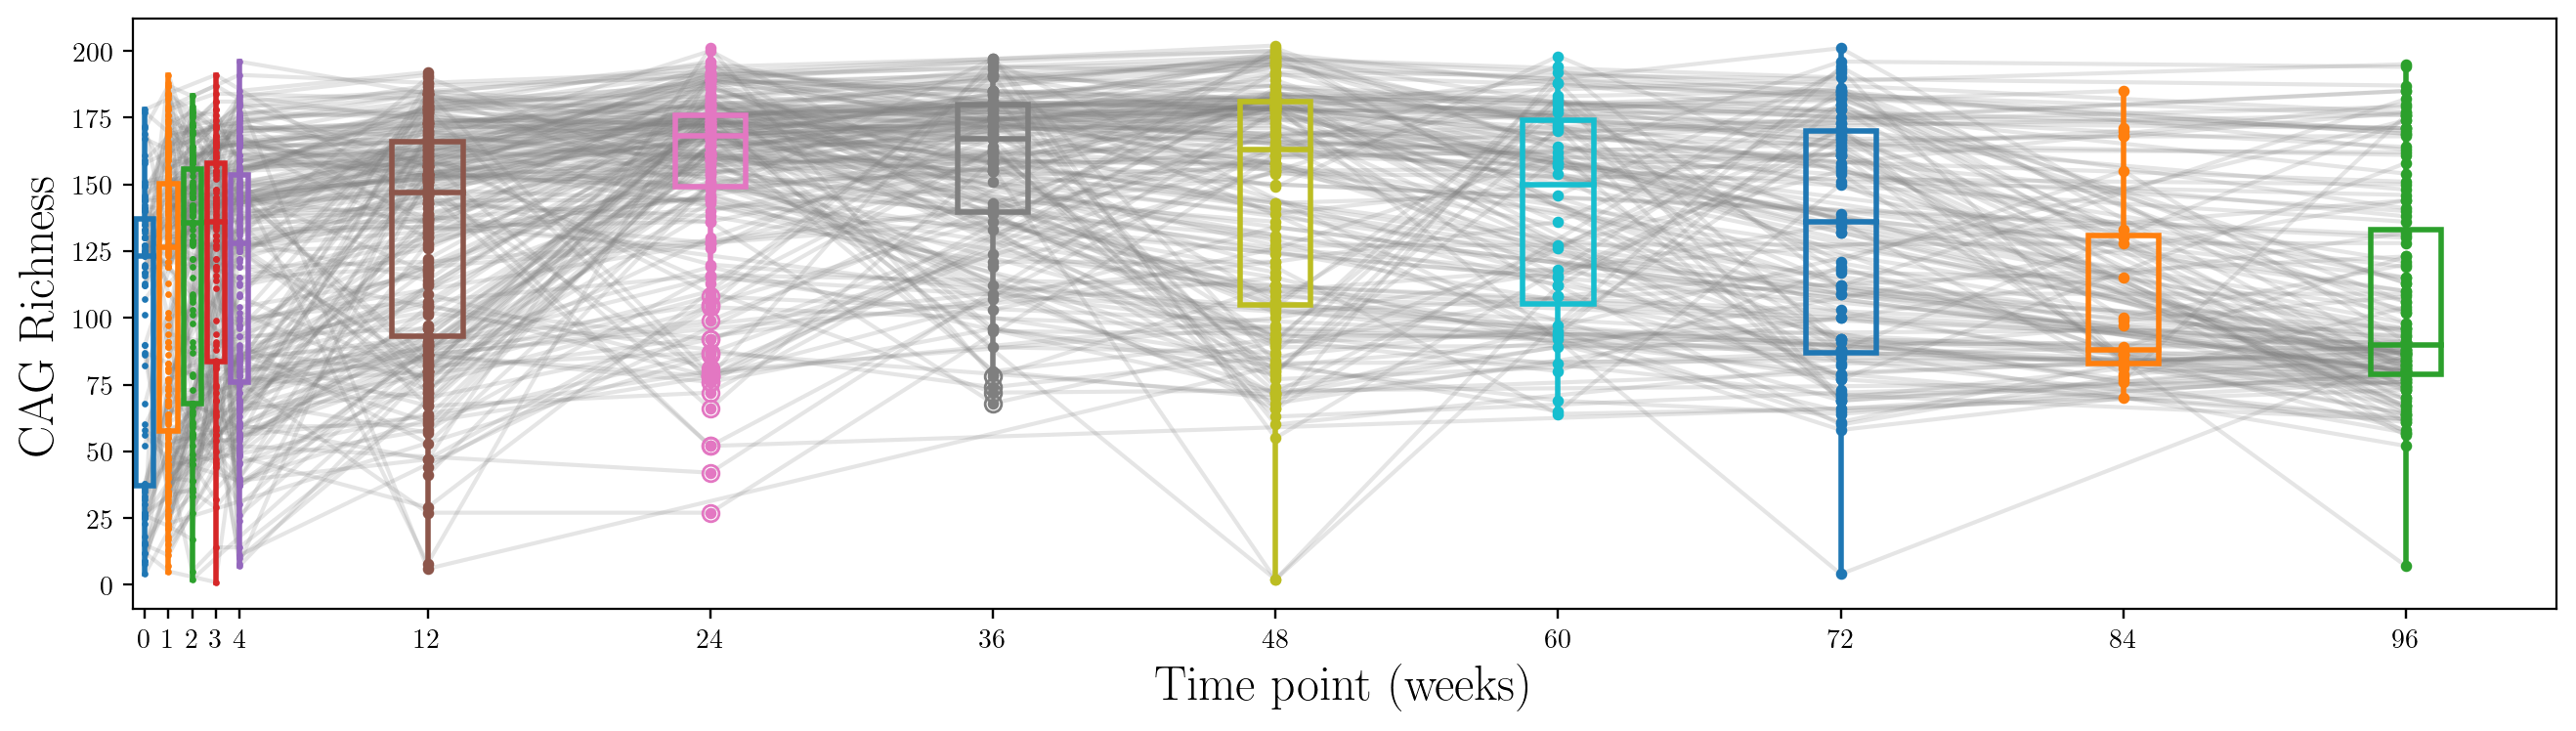

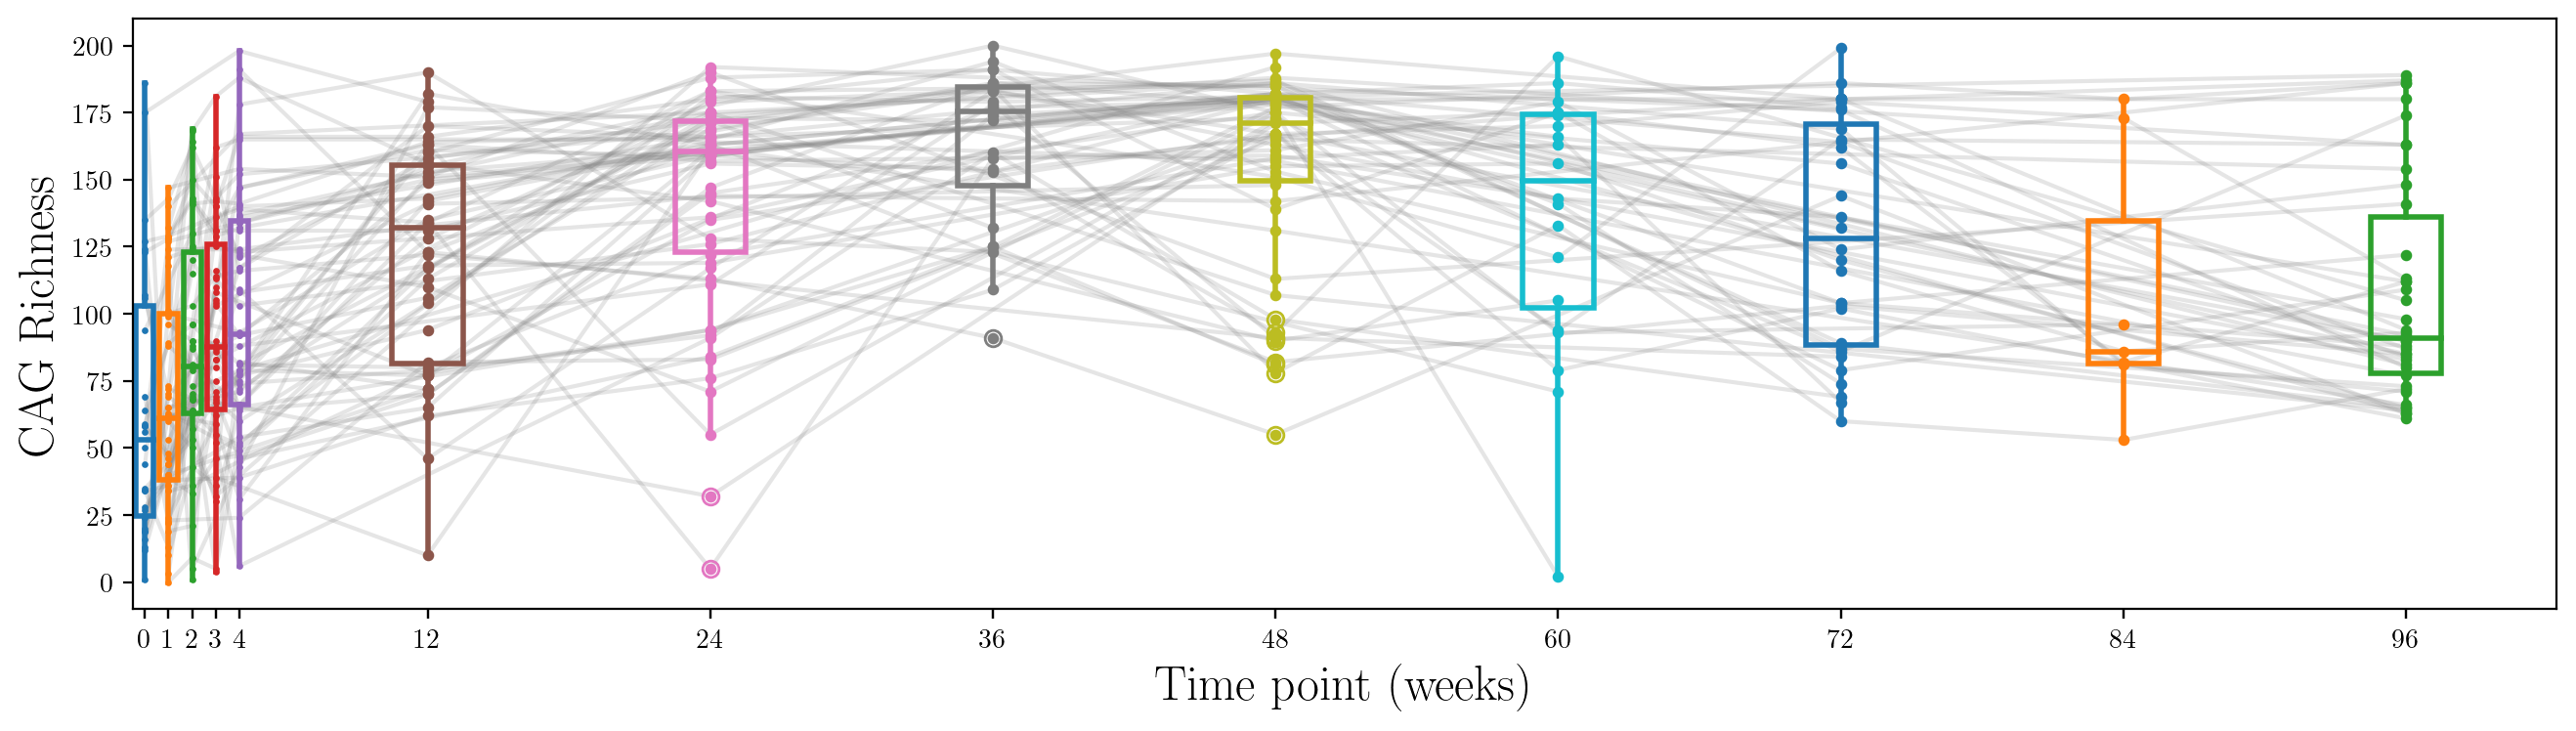

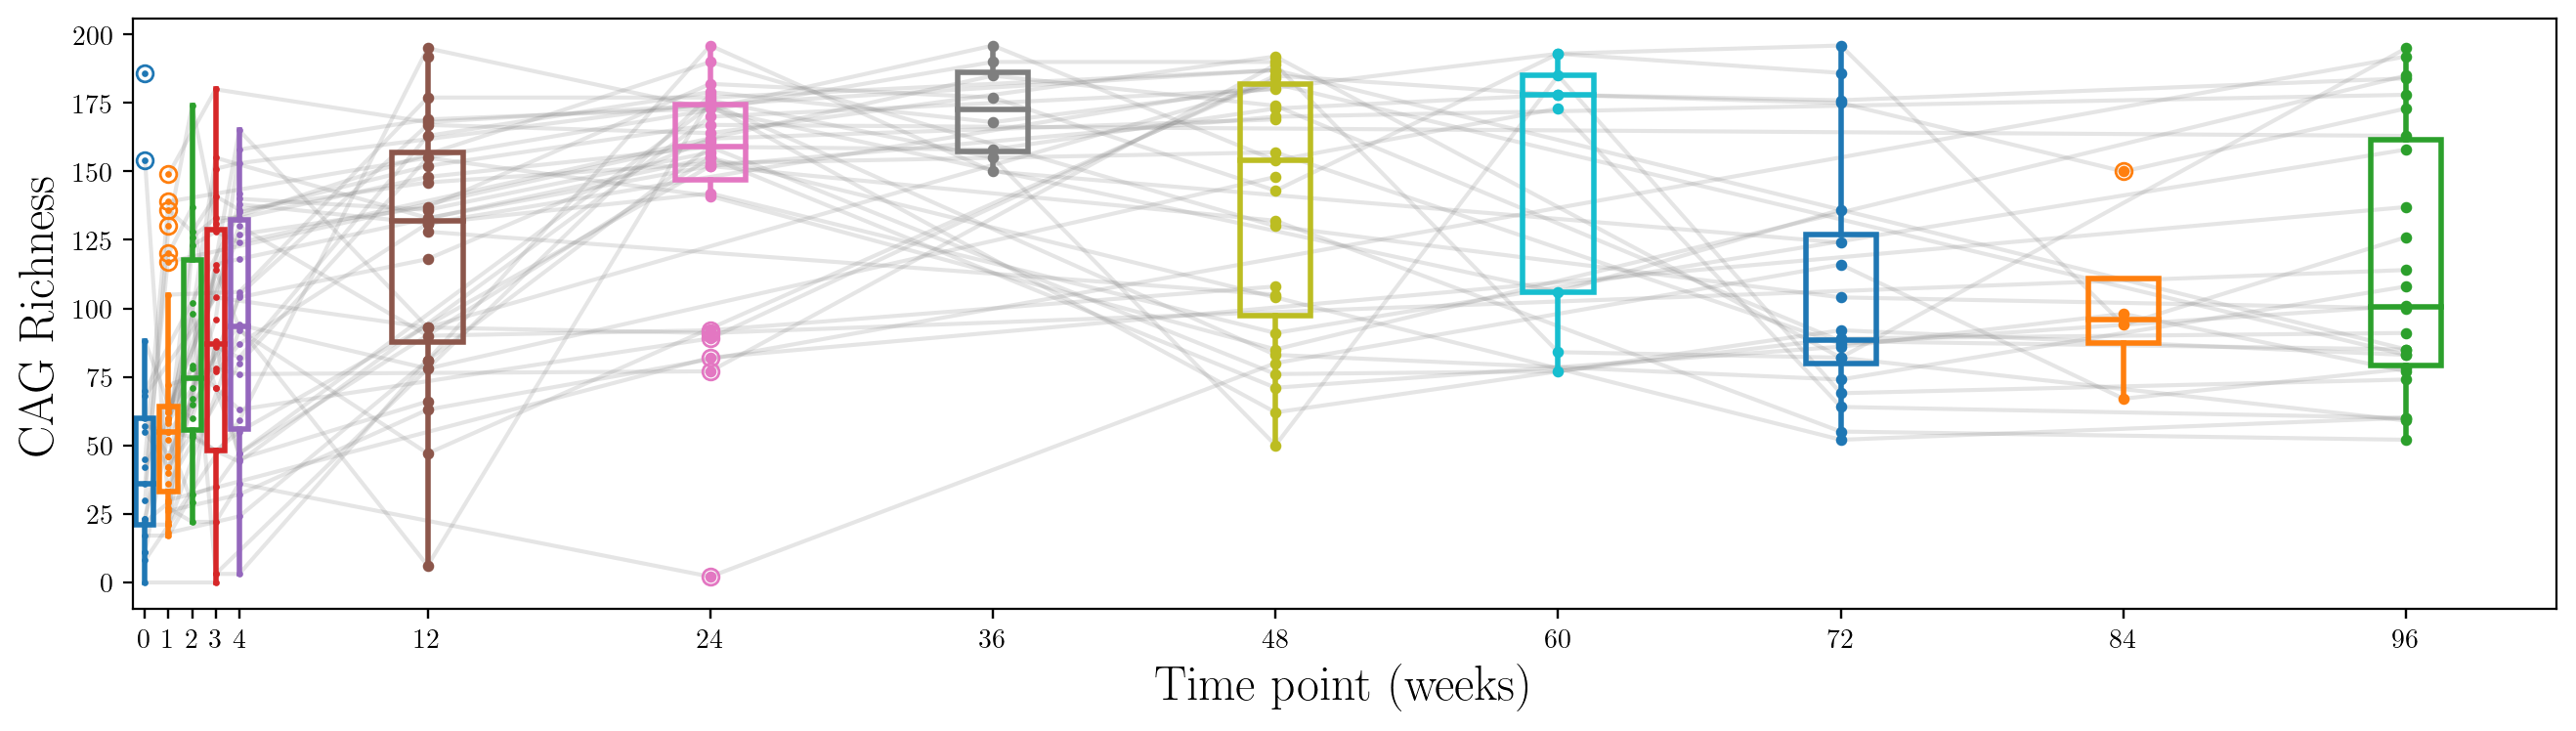

In [47]:
plot_index("CAG Richness")

Vaginal
C-section with labor
C-section without labor


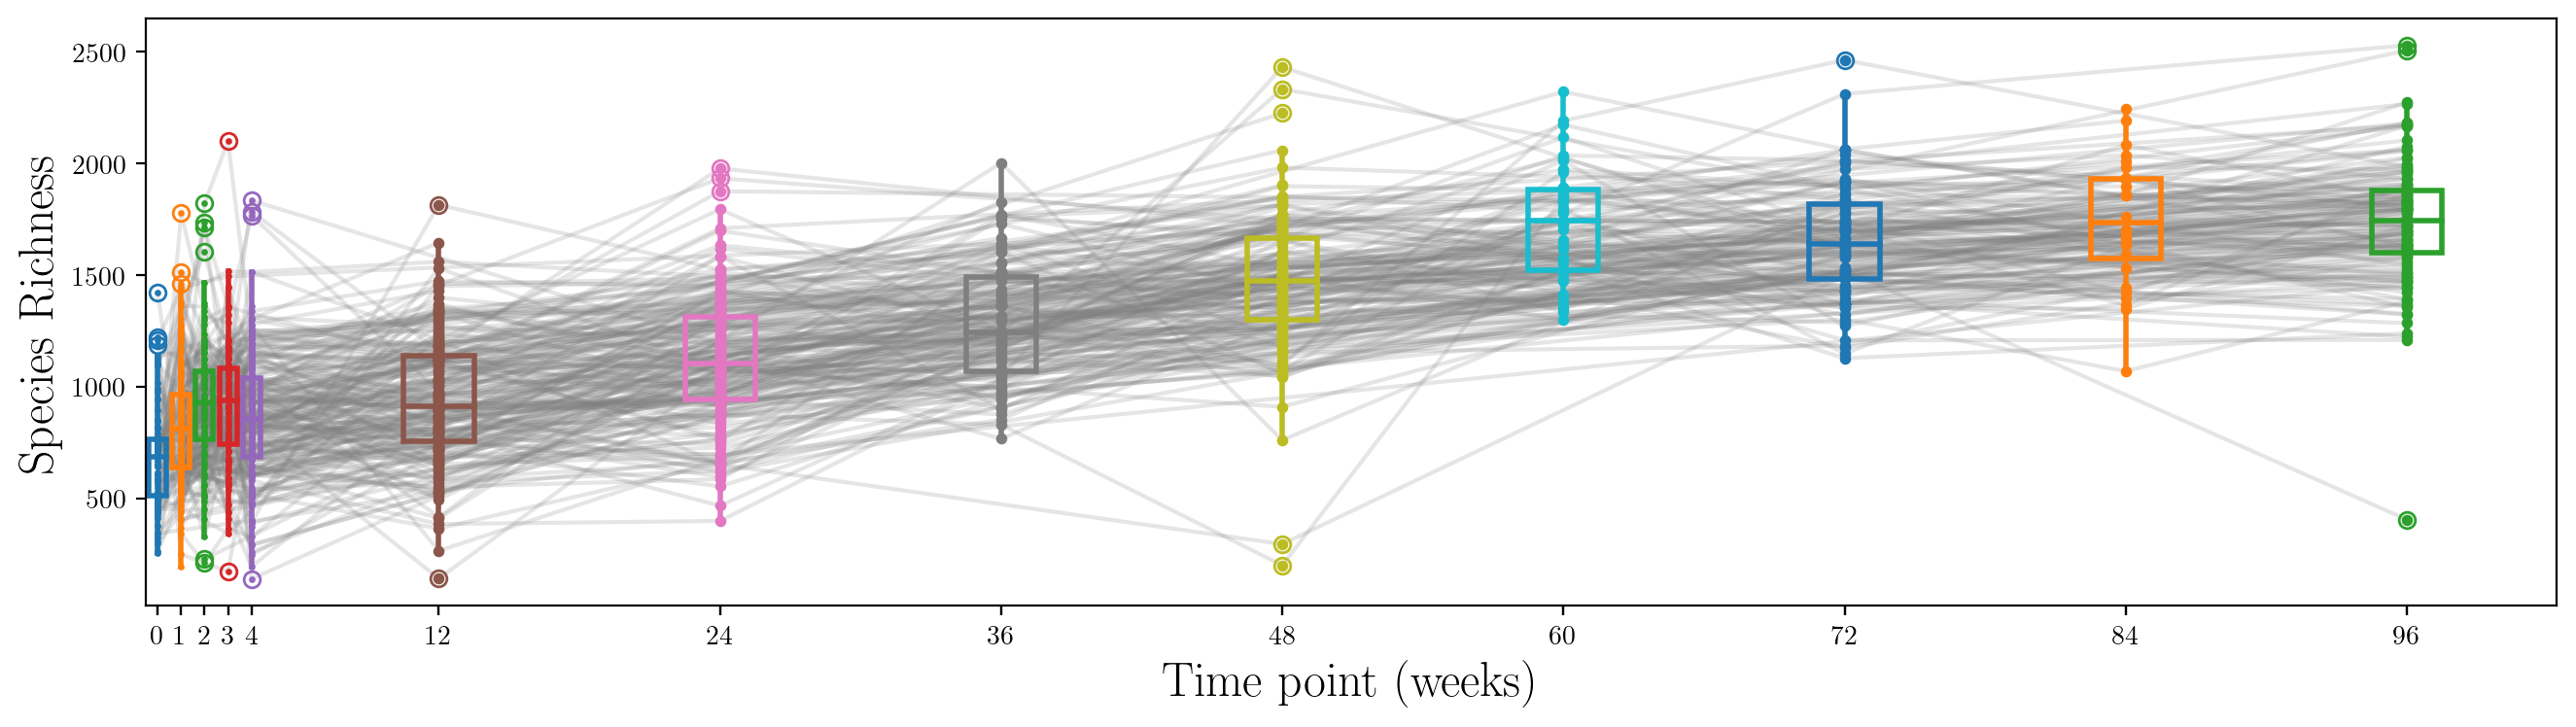

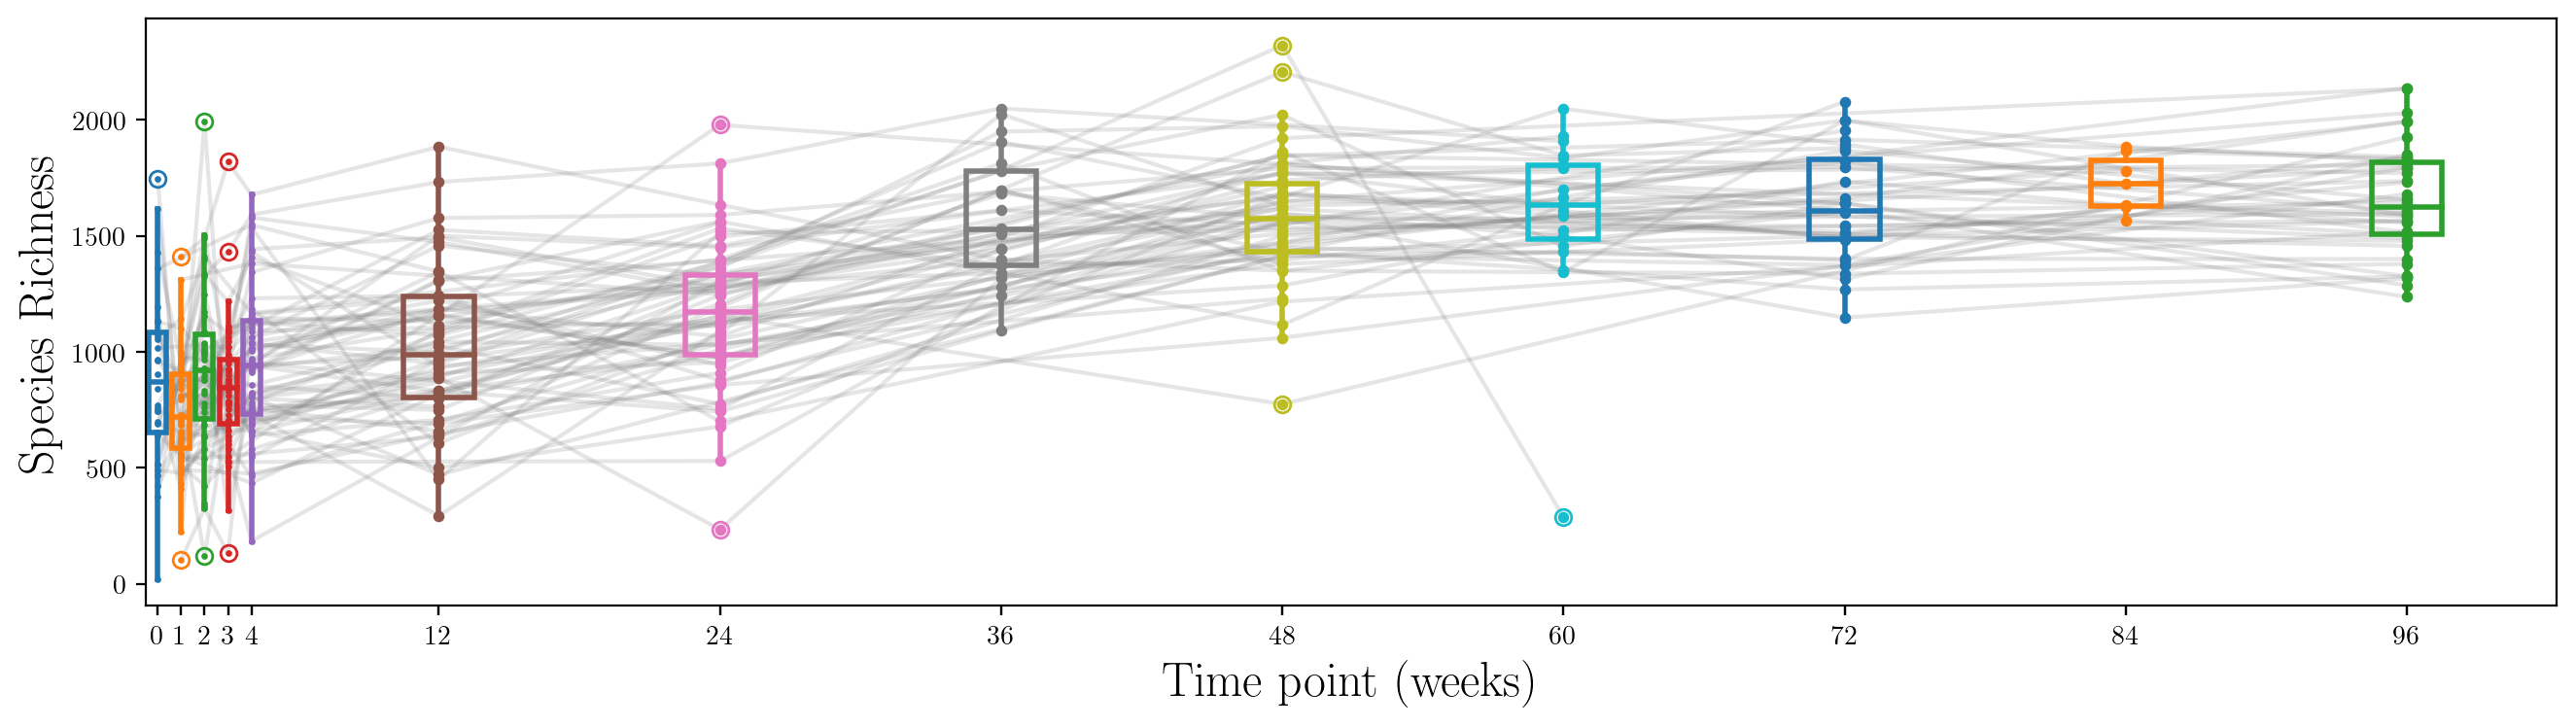

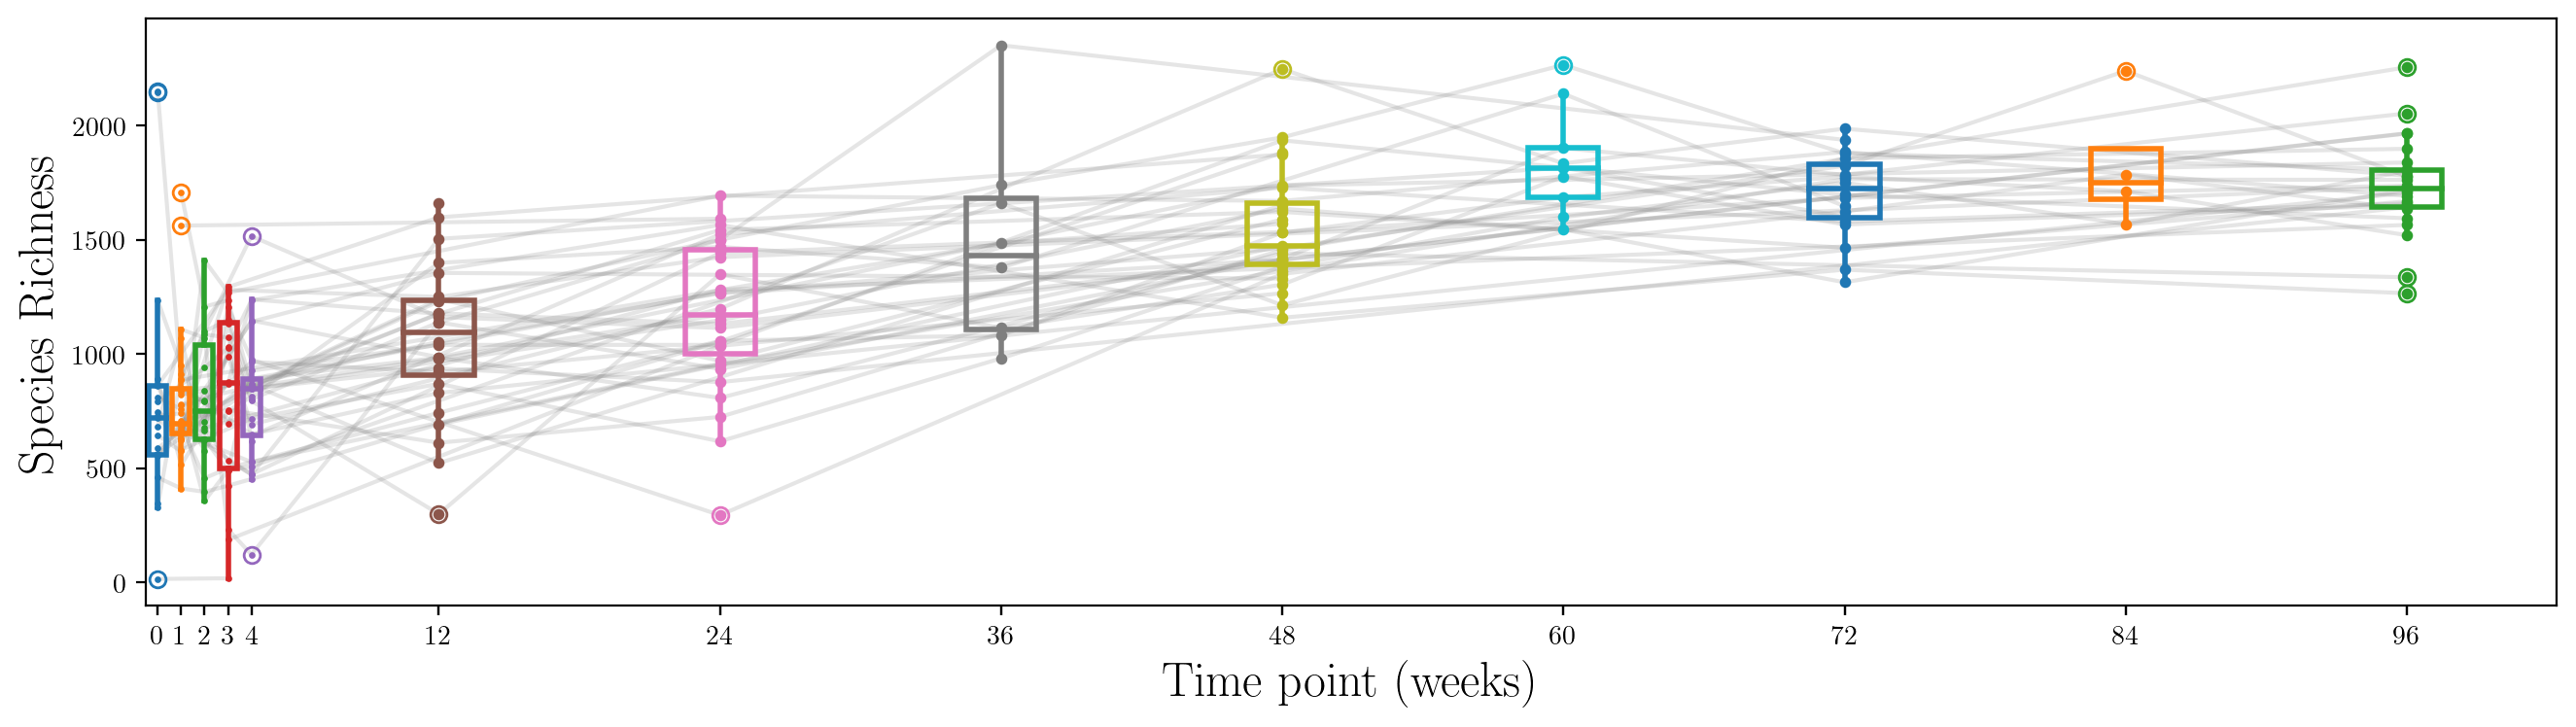

In [48]:
plot_index("Species Richness")